In [ ]:
%pip install -U "jax[cuda]"

In [ ]:
%pip install -U "git+https://github.com/briancf1/QDax.git#egg=qdax[examples]"

In [ ]:
# Clone the repository to get experiment scripts
!git clone https://github.com/briancf1/QDax.git
%cd QDax/examples

## STEP 1: Setup and Configuration

In [1]:
import os
import json
import time
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import functools
import warnings
warnings.filterwarnings('ignore')

import jax
import jax.numpy as jnp

from qdax.core.dns_ga import DominatedNoveltySearchGA
from qdax.core.dns import DominatedNoveltySearch
import qdax.tasks.brax as environments
from qdax.tasks.brax.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.metrics import CSVLogger, default_qd_metrics

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Create experiment logs directory
os.makedirs("seed_variability_logs_walker2d_uni_iso_0.01", exist_ok=True)

print("Setup complete!")
print(f"Current directory: {os.getcwd()}")
print(f"JAX devices: {jax.devices()}")

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Setup complete!
Current directory: /Users/briancf/Desktop/source/EvoAlgsAndSwarm/lib-qdax/QDax/examples
JAX devices: [CpuDevice(id=0)]


## Generate Random Seeds

In [2]:
# Generate 31 random seeds for robust statistical analysis
np.random.seed(2024)  # Fixed seed for reproducibility of seed generation
RANDOM_SEEDS = np.random.randint(1, 100000, size=31).tolist()

print("="*80)
print("GENERATED 31 RANDOM SEEDS")
print("="*80)
print(f"Seeds: {RANDOM_SEEDS[:10]}... (showing first 10)")
print(f"Range: {min(RANDOM_SEEDS)} to {max(RANDOM_SEEDS)}")
print(f"Total: {len(RANDOM_SEEDS)} seeds")
print("="*80)

# Save seeds for reproducibility
with open('seed_variability_logs_walker2d_uni_iso_0.01/random_seeds.json', 'w') as f:
    json.dump({'seeds': RANDOM_SEEDS, 'generation_seed': 2024}, f, indent=2)

GENERATED 31 RANDOM SEEDS
Seeds: [7817, 52731, 51809, 35457, 47644, 95781, 68031, 49336, 7978, 61378]... (showing first 10)
Range: 317 to 99314
Total: 31 seeds


## Experiment Configuration

In [ ]:
FIXED_PARAMS = {
    'batch_size': 100,
    'env_name': 'walker2d_uni',  # Ant Blocks from DNS paper: obstacles + final xy position
    'episode_length': 100,
    'num_iterations': 3000,
    'policy_hidden_layer_sizes': (64, 64),
    'population_size': 1024,
    'k': 3,
    'line_sigma': 0.05,
    'iso_sigma': 0.01,  # Best performer from previous experiments
}

# Main experimental configurations (run with all 31 seeds)
MAIN_CONFIGS = [
    # Baseline (no GA)
    {
        'type': 'baseline',
        'name': 'DNS_baseline',
        'g_n': None,
        'num_ga_children': None,
        'num_ga_generations': None,
    },
    # Frequent GA calls (10 times during 3000 iterations)
    {
        'type': 'dns-ga',
        'name': 'DNS-GA_g300_gen2',
        'g_n': 300,
        'num_ga_children': 2,
        'num_ga_generations': 2,
    },
    # Rare but deep GA calls (3 times during 3000 iterations, seed 42's winner)
    {
        'type': 'dns-ga',
        'name': 'DNS-GA_g1000_gen4',
        'g_n': 1000,
        'num_ga_children': 2,
        'num_ga_generations': 4,
    },
]

# Sanity check: DNS-GA with g_n so large it never triggers (should match baseline)
SANITY_CONFIG = {
    'type': 'dns-ga',
    'name': 'DNS-GA_sanity_no_ga',
    'g_n': 99999,  # Never triggers within 3000 iterations
    'num_ga_children': 2,
    'num_ga_generations': 2,
}

# Sanity check runs with just seed 42
SANITY_SEED = 42

print("="*80)
print("EXPERIMENT CONFIGURATION")
print("="*80)
print(f"\nFixed Parameters:")
print(f"  Environment: {FIXED_PARAMS['env_name']}")
print(f"  Iterations: {FIXED_PARAMS['num_iterations']}")
print(f"  Batch size: {FIXED_PARAMS['batch_size']}")
print(f"  ISO_SIGMA: {FIXED_PARAMS['iso_sigma']}")
print(f"  Population: {FIXED_PARAMS['population_size']}")

print(f"\nMain Configurations (31 seeds each):")
for config in MAIN_CONFIGS:
    if config['type'] == 'baseline':
        print(f"  • {config['name']}: No GA")
    else:
        ga_calls = FIXED_PARAMS['num_iterations'] // config['g_n']
        print(f"  • {config['name']}: {ga_calls} GA calls (every {config['g_n']} iters, {config['num_ga_generations']} gens)")

print(f"\nSanity Check Configuration (seed {SANITY_SEED} only):")
print(f"  • {SANITY_CONFIG['name']}: g_n={SANITY_CONFIG['g_n']} (no GA triggers)")
print(f"    Purpose: Verify DNS-GA without GA = baseline")

print(f"\nTotal Experiments:")
main_exp = len(MAIN_CONFIGS) * len(RANDOM_SEEDS)
sanity_exp = 1
total_exp = main_exp + sanity_exp
print(f"  Main: {len(MAIN_CONFIGS)} configs × {len(RANDOM_SEEDS)} seeds = {main_exp}")
print(f"  Sanity: {sanity_exp}")
print(f"  Total: {total_exp}")
print(f"  Estimated time (2 parallel): ~{(total_exp / 2) * 3.3 / 60:.1f} hours")
print("="*80)

EXPERIMENT CONFIGURATION

Fixed Parameters:
  Environment: ant_omni
  Iterations: 3000
  Batch size: 100
  ISO_SIGMA: 0.01
  Population: 1024

Main Configurations (31 seeds each):
  • DNS_baseline: No GA
  • DNS-GA_g300_gen2: 10 GA calls (every 300 iters, 2 gens)
  • DNS-GA_g1000_gen4: 3 GA calls (every 1000 iters, 4 gens)

Sanity Check Configuration (seed 42 only):
  • DNS-GA_sanity_no_ga: g_n=99999 (no GA triggers)
    Purpose: Verify DNS-GA without GA = baseline

Total Experiments:
  Main: 3 configs × 31 seeds = 93
  Sanity: 1
  Total: 94
  Estimated time (2 parallel): ~2.6 hours


## STEP 2: Helper Functions

In [4]:
def calculate_ga_overhead_evals(g_n, num_iterations, population_size, num_ga_children, num_ga_generations):
    """Calculate total evaluations performed by Competition-GA."""
    if g_n is None or g_n >= num_iterations:
        return 0, 0, 0
    
    num_ga_calls = num_iterations // g_n
    if num_ga_children == 1:
        offspring_per_call = population_size * num_ga_generations
    else:
        offspring_per_call = population_size * num_ga_children * (num_ga_children**num_ga_generations - 1) // (num_ga_children - 1)
    evals_per_ga_call = offspring_per_call
    total_ga_evals = num_ga_calls * evals_per_ga_call
    return total_ga_evals, num_ga_calls, evals_per_ga_call


def setup_environment(env_name, episode_length, policy_hidden_layer_sizes, batch_size, seed):
    """Initialize environment and policy network."""
    env = environments.create(env_name, episode_length=episode_length)
    reset_fn = jax.jit(env.reset)
    key = jax.random.key(seed)
    
    policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
    policy_network = MLP(
        layer_sizes=policy_layer_sizes,
        kernel_init=jax.nn.initializers.lecun_uniform(),
        final_activation=jnp.tanh,
    )
    
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num=batch_size)
    fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
    init_variables = jax.vmap(policy_network.init)(keys, fake_batch)
    
    return env, policy_network, reset_fn, init_variables, key


def create_scoring_function(env, policy_network, reset_fn, episode_length, env_name):
    """Create scoring function for fitness evaluation."""
    def play_step_fn(env_state, policy_params, key):
        actions = policy_network.apply(policy_params, env_state.obs)
        state_desc = env_state.info["state_descriptor"]
        next_state = env.step(env_state, actions)
        
        transition = QDTransition(
            obs=env_state.obs,
            next_obs=next_state.obs,
            rewards=next_state.reward,
            dones=next_state.done,
            actions=actions,
            truncations=next_state.info["truncation"],
            state_desc=state_desc,
            next_state_desc=next_state.info["state_descriptor"],
        )
        return next_state, policy_params, key, transition
    
    descriptor_extraction_fn = environments.descriptor_extractor[env_name]
    scoring_fn = functools.partial(
        scoring_function,
        episode_length=episode_length,
        play_reset_fn=reset_fn,
        play_step_fn=play_step_fn,
        descriptor_extractor=descriptor_extraction_fn,
    )
    
    return scoring_fn


def create_mutation_function(iso_sigma):
    """Create mutation function for Competition-GA."""
    def competition_ga_mutation_fn(genotype, key):
        genotype_flat, tree_def = jax.tree_util.tree_flatten(genotype)
        num_leaves = len(genotype_flat)
        keys = jax.random.split(key, num_leaves)
        keys_tree = jax.tree_util.tree_unflatten(tree_def, keys)
        
        def add_noise(x, k):
            return x + jax.random.normal(k, shape=x.shape) * iso_sigma
        
        mutated = jax.tree_util.tree_map(add_noise, genotype, keys_tree)
        return mutated
    
    return competition_ga_mutation_fn


def calculate_cumulative_evals_for_log(config, log_df, batch_size, population_size):
    """Calculate cumulative evaluations at each logged iteration."""
    iterations = log_df['iteration'].values
    evals = np.zeros(len(iterations))
    
    if config['type'] == 'baseline':
        # Baseline: constant batch_size per iteration
        evals = iterations * batch_size
    else:
        # DNS-GA: batch_size + periodic GA overhead
        g_n = config['g_n']
        num_ga_children = config['num_ga_children']
        num_ga_generations = config['num_ga_generations']
        
        # Calculate GA overhead per call
        if g_n >= len(iterations) * 100:  # Sanity check: g_n so large it never triggers
            evals = iterations * batch_size
        elif num_ga_children == 1:
            ga_evals_per_call = population_size * num_ga_generations
            for idx, iter_num in enumerate(iterations):
                cumulative = iter_num * batch_size
                num_ga_calls = iter_num // g_n
                cumulative += num_ga_calls * ga_evals_per_call
                evals[idx] = cumulative
        else:
            ga_evals_per_call = (population_size * num_ga_children * 
                                (num_ga_children**num_ga_generations - 1) // (num_ga_children - 1))
            for idx, iter_num in enumerate(iterations):
                cumulative = iter_num * batch_size
                num_ga_calls = iter_num // g_n
                cumulative += num_ga_calls * ga_evals_per_call
                evals[idx] = cumulative
    
    return evals


def interpolate_evals_to_milestone(qd_scores, evals, milestone):
    """Interpolate evaluations needed to reach a QD score milestone."""
    idx = np.searchsorted(qd_scores, milestone)
    
    if idx == 0:
        return evals[0]
    elif idx >= len(qd_scores):
        return None  # Milestone not reached
    else:
        # Linear interpolation between two points
        qd_low, qd_high = qd_scores[idx-1], qd_scores[idx]
        eval_low, eval_high = evals[idx-1], evals[idx]
        ratio = (milestone - qd_low) / (qd_high - qd_low)
        return eval_low + ratio * (eval_high - eval_low)

print("Helper functions loaded!")

Helper functions loaded!


## STEP 3: Parallel Experiment Runner

In [5]:
def run_single_experiment(config, seed, fixed_params):
    """Run a single experiment with given config and seed."""
    exp_name = f"{config['name']}_seed{seed}"
    
    # Setup environment
    env, policy_network, reset_fn, init_variables, key = setup_environment(
        fixed_params['env_name'],
        fixed_params['episode_length'],
        fixed_params['policy_hidden_layer_sizes'],
        fixed_params['batch_size'],
        seed
    )
    
    scoring_fn = create_scoring_function(env, policy_network, reset_fn, 
                                        fixed_params['episode_length'],
                                        fixed_params['env_name'])
    
    reward_offset = environments.reward_offset[fixed_params['env_name']]
    metrics_function = functools.partial(
        default_qd_metrics,
        qd_offset=reward_offset * fixed_params['episode_length'],
    )
    
    # Create emitter
    variation_fn = functools.partial(
        isoline_variation,
        iso_sigma=fixed_params['iso_sigma'],
        line_sigma=fixed_params['line_sigma']
    )
    
    mixing_emitter = MixingEmitter(
        mutation_fn=None,
        variation_fn=variation_fn,
        variation_percentage=1.0,
        batch_size=fixed_params['batch_size']
    )
    
    # Create algorithm (DNS or DNS-GA)
    if config['type'] == 'baseline':
        algorithm = DominatedNoveltySearch(
            scoring_function=scoring_fn,
            emitter=mixing_emitter,
            metrics_function=metrics_function,
            population_size=fixed_params['population_size'],
            k=fixed_params['k'],
        )
    else:
        mutation_fn = create_mutation_function(fixed_params['iso_sigma'])
        algorithm = DominatedNoveltySearchGA(
            scoring_function=scoring_fn,
            emitter=mixing_emitter,
            metrics_function=metrics_function,
            population_size=fixed_params['population_size'],
            k=fixed_params['k'],
            g_n=config['g_n'],
            num_ga_children=config['num_ga_children'],
            num_ga_generations=config['num_ga_generations'],
            mutation_fn=mutation_fn,
        )
    
    # Initialize
    key, subkey = jax.random.split(key)
    repertoire, emitter_state, init_metrics = algorithm.init(init_variables, subkey)
    
    # Setup logging
    log_period = 100
    num_loops = fixed_params['num_iterations'] // log_period
    
    metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}
    init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
    init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
    init_metrics["time"] = jnp.array([0.0])
    metrics = jax.tree.map(
        lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0),
        metrics, init_metrics
    )
    
    log_filename = os.path.join("seed_variability_logs", f"{exp_name}_logs.csv")
    csv_logger = CSVLogger(log_filename, header=list(metrics.keys()))
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))
    
    # Main training loop
    if config['type'] == 'baseline':
        algorithm_scan_update = algorithm.scan_update
        scan_state = (repertoire, emitter_state, key)
    else:
        algorithm_scan_update = algorithm.scan_update
        scan_state = (repertoire, emitter_state, key, 1)  # generation_counter
    
    start_time_total = time.time()
    
    for i in range(num_loops):
        start_time = time.time()
        
        scan_state, current_metrics = jax.lax.scan(
            algorithm_scan_update,
            scan_state,
            (),
            length=log_period,
        )
        
        timelapse = time.time() - start_time
        
        current_metrics["iteration"] = jnp.arange(
            1 + log_period * i, 1 + log_period * (i + 1), dtype=jnp.int32
        )
        current_metrics["time"] = jnp.repeat(timelapse, log_period)
        metrics = jax.tree.map(
            lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0),
            metrics, current_metrics
        )
        
        csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))
    
    total_time = time.time() - start_time_total
    
    # Calculate metrics
    ga_total_evals, ga_num_calls, ga_evals_per_call = calculate_ga_overhead_evals(
        config.get('g_n'), fixed_params['num_iterations'], fixed_params['population_size'],
        config.get('num_ga_children'), config.get('num_ga_generations')
    )
    
    return {
        'config_name': config['name'],
        'config_type': config['type'],
        'seed': seed,
        'g_n': config.get('g_n'),
        'num_ga_generations': config.get('num_ga_generations'),
        'final_qd_score': float(metrics['qd_score'][-1]),
        'final_max_fitness': float(metrics['max_fitness'][-1]),
        'final_coverage': float(metrics['coverage'][-1]),
        'total_time': total_time,
        'ga_overhead_evals': ga_total_evals,
        'log_file': log_filename,
    }

print("Helper functions ready!")

Helper functions ready!


## STEP 4: Build Experiment Queue and Execute

In [6]:
# Build experiment queue
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("="*80)
print(f"BUILDING EXPERIMENT QUEUE - {timestamp}")
print("="*80)

experiment_queue = []
exp_num = 0

# SANITY CHECK: Run baseline seed 42 FIRST to establish reference
baseline_config = [c for c in MAIN_CONFIGS if c['type'] == 'baseline'][0]
exp_num += 1
experiment_queue.append((exp_num, exp_num, baseline_config, SANITY_SEED))

# Then run DNS-GA with g_n=99999 (should be slightly different but comparable)
exp_num += 1
experiment_queue.append((exp_num, exp_num, SANITY_CONFIG, SANITY_SEED))

# Add main experiments (all configs × all seeds)
for config in MAIN_CONFIGS:
    for seed in RANDOM_SEEDS:
        exp_num += 1
        experiment_queue.append((exp_num, exp_num, config, seed))

total_experiments = len(experiment_queue)

print(f"\nExperiment Queue Summary:")
print(f"  SANITY CHECK FIRST: 2 experiments (DNS-GA g_n=99999 + baseline, both seed 42)")
print(f"  Main experiments: {len(MAIN_CONFIGS)} configs × {len(RANDOM_SEEDS)} seeds = {len(MAIN_CONFIGS) * len(RANDOM_SEEDS)}")
print(f"  Total: {total_experiments}")
print(f"  Execution: Sequential (Jupyter can't use multiprocessing)")
print(f"  Estimated time: ~{total_experiments * 3.3 / 60:.1f} hours (~5.2 hours)")
print("="*80)

print(f"\n🔍 FIRST 2 EXPERIMENTS (SANITY CHECK):")
for i in range(min(2, len(experiment_queue))):
    exp_num, _, config, seed = experiment_queue[i]
    print(f"  {exp_num}. {config['name']}, seed={seed}")
print(f"  → These should have IDENTICAL final QD scores")
print(f"  → If they differ by >0.5%, stop the run and investigate")

print(f"\nNext 5 experiments:")
for i in range(2, min(7, len(experiment_queue))):
    exp_num, _, config, seed = experiment_queue[i]
    print(f"  {exp_num}. {config['name']}, seed={seed}")

print("\nLast 3 experiments:")
for i in range(max(0, len(experiment_queue) - 3), len(experiment_queue)):
    exp_num, _, config, seed = experiment_queue[i]
    print(f"  {exp_num}. {config['name']}, seed={seed}")

print("\n" + "="*80)
print("Ready to run experiments!")
print("="*80)

BUILDING EXPERIMENT QUEUE - 20251116_083926

Experiment Queue Summary:
  SANITY CHECK FIRST: 2 experiments (DNS-GA g_n=99999 + baseline, both seed 42)
  Main experiments: 3 configs × 31 seeds = 93
  Total: 95
  Execution: Sequential (Jupyter can't use multiprocessing)
  Estimated time: ~5.2 hours (~5.2 hours)

🔍 FIRST 2 EXPERIMENTS (SANITY CHECK):
  1. DNS_baseline, seed=42
  2. DNS-GA_sanity_no_ga, seed=42
  → These should have IDENTICAL final QD scores
  → If they differ by >0.5%, stop the run and investigate

Next 5 experiments:
  3. DNS_baseline, seed=7817
  4. DNS_baseline, seed=52731
  5. DNS_baseline, seed=51809
  6. DNS_baseline, seed=35457
  7. DNS_baseline, seed=47644

Last 3 experiments:
  93. DNS-GA_g1000_gen4, seed=53095
  94. DNS-GA_g1000_gen4, seed=51931
  95. DNS-GA_g1000_gen4, seed=35573

Ready to run experiments!


In [ ]:
# STEP 4: Run All Experiments in Parallel with ipyparallel
print("\n" + "="*80)
print("RUNNING ALL EXPERIMENTS WITH ipyparallel")
print("="*80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total experiments: {len(experiment_queue)}")
print(f"Setting up parallel cluster with 2 engines...")
print("="*80)

start_time_all = time.time()

import ipyparallel as ipp

# Start a local cluster with 2 engines
cluster = ipp.Cluster(n=2)
rc = cluster.start_and_connect_sync()

print(f"✓ Cluster started with {len(rc)} engines")
print(f"  Estimated time: ~{len(experiment_queue) / 2 * 3.3 / 60:.1f} hours")

# Push necessary imports to engines using execute (more reliable than sync_imports)
rc[:].execute("""
import jax
import jax.numpy as jnp
import functools
import time
import os
import json
from qdax.core.dns_ga import DominatedNoveltySearchGA
from qdax.core.dns import DominatedNoveltySearch
import qdax.tasks.brax as environments
from qdax.tasks.brax.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.metrics import CSVLogger, default_qd_metrics
""").wait()

# Push FIXED_PARAMS and helper functions to engines using .push()
rc[:].push({
    'FIXED_PARAMS': FIXED_PARAMS,
    'setup_environment': setup_environment,
    'create_scoring_function': create_scoring_function,
    'create_mutation_function': create_mutation_function,
    'calculate_ga_overhead_evals': calculate_ga_overhead_evals,
    'calculate_cumulative_evals_for_log': calculate_cumulative_evals_for_log,
    'interpolate_evals_to_milestone': interpolate_evals_to_milestone,
    'run_single_experiment': run_single_experiment
}).wait()

print("✓ Engines initialized with functions and parameters")

# Create load-balanced view
lview = rc.load_balanced_view()

# Define wrapper function for ipyparallel
def run_experiment_wrapper(exp_tuple):
    exp_num, total_exp, config, seed = exp_tuple
    try:
        result = run_single_experiment(config, seed, FIXED_PARAMS)
        result['exp_num'] = exp_num
        return ('success', result)
    except Exception as e:
        return ('error', {'config_name': config['name'], 'seed': seed, 'error': str(e)})

# Push wrapper to engines using .push()
rc[:].push({'run_experiment_wrapper': run_experiment_wrapper}).wait()

# Submit ALL experiments (including sanity check)
print("Submitting all experiments to cluster...")
async_results = []
for exp_tuple in experiment_queue:
    ar = lview.apply_async(run_experiment_wrapper, exp_tuple)
    async_results.append(ar)

print(f"✓ Submitted {len(async_results)} experiments")
print("\nMonitoring progress (updates every 10 seconds)...")
print("Note: Each experiment takes ~3-4 minutes")

# Monitor progress with non-blocking checks
all_results = []
errors = []
completed_count = 0
last_update = time.time()

while completed_count < len(async_results):
    # Check all results non-blocking
    for idx, ar in enumerate(async_results):
        if ar.ready() and not hasattr(ar, '_collected'):
            ar._collected = True  # Mark as collected
            status, result = ar.result()
            
            if status == 'success':
                all_results.append(result)
                config_name = result['config_name']
                seed = result['seed']
                qd = result['final_qd_score']
                print(f"  ✓ Completed: {config_name}, seed={seed}, QD={qd:.1f}")
            else:
                errors.append(result)
                print(f"  ✗ Failed: {result['config_name']}, seed={result['seed']}")
            
            completed_count += 1
    
    # Progress update every 10 seconds
    if time.time() - last_update > 10:
        elapsed = time.time() - start_time_all
        pct = completed_count / len(experiment_queue) * 100
        if completed_count > 0:
            avg_time = elapsed / completed_count
            remaining_time = (len(experiment_queue) - completed_count) * avg_time / 3600
            print(f"📊 Progress: {completed_count}/{len(experiment_queue)} ({pct:.1f}%) | Elapsed: {elapsed/60:.1f}m | Remaining: ~{remaining_time:.2f}h")
        else:
            print(f"📊 Waiting for first experiment to complete... ({elapsed:.0f}s elapsed)")
        last_update = time.time()
    
    time.sleep(2)  # Check every 2 seconds

# Cleanup
cluster.stop_cluster_sync()
print("\n✓ Cluster stopped")

total_time = time.time() - start_time_all

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE!")
print("="*80)
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total time: {total_time / 60:.1f} minutes ({total_time / 3600:.2f} hours)")
print(f"Successful experiments: {len(all_results)}")
print(f"Failed experiments: {len(errors)}")

if errors:
    print("\nErrors encountered:")
    for error in errors:
        print(f"  • {error['config_name']}, seed={error['seed']}: {error['error']}")

# Save all results
results_file = f"seed_variability_logs_walker2d_uni_iso_0.01/all_results_{timestamp}.json"
with open(results_file, 'w') as f:
    json.dump({
        'results': all_results,
        'errors': errors,
        'total_time': total_time,
        'timestamp': timestamp,
        'num_seeds': len(RANDOM_SEEDS),
        'seeds': RANDOM_SEEDS,
    }, f, indent=2)


print(f"\nResults saved to: {results_file}")
print("="*80)


RUNNING ALL EXPERIMENTS WITH ipyparallel
Start time: 2025-11-15 20:29:10
Total experiments: 95
Setting up parallel cluster with 2 engines...
Starting 2 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
Starting 2 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

✓ Cluster started with 2 engines
  Estimated time: ~2.6 hours
✓ Engines initialized
Submitting all experiments to cluster...
✓ Submitted 95 experiments

Monitoring progress (updates every 10 seconds)...
Note: Each experiment takes ~3-4 minutes
✓ Engines initialized
Submitting all experiments to cluster...
✓ Submitted 95 experiments

Monitoring progress (updates every 10 seconds)...
Note: Each experiment takes ~3-4 minutes
📊 Waiting for first experiment to complete... (19s elapsed)
📊 Waiting for first experiment to complete... (19s elapsed)
📊 Waiting for first experiment to complete... (29s elapsed)
📊 Waiting for first experiment to complete... (29s elapsed)
📊 Waiting for first experiment to complete... (39s elapsed)
📊 Waiting for first experiment to complete... (39s elapsed)
📊 Waiting for first experiment to complete... (49s elapsed)
📊 Waiting for first experiment to complete... (49s elapsed)
📊 Waiting for first experiment to complete... (59s elapsed)
📊 Waiting for first experiment to 

KeyboardInterrupt: 

Controller stopped: {'exit_code': 0, 'pid': 152, 'identifier': 'ipcontroller-1763260150-f65o-94312'}


## STEP 5: Convergence Efficiency Analysis

**Goal**: Calculate how many evaluations each DNS-GA config needs to reach baseline's convergence score

**Key Metric**: Evaluations-to-convergence (not performance at same iteration)

In [7]:
# Load results from JSON file
import glob
import json

log_dir = "seed_variability_logs_walker2d_uni_iso_0.01"
results_files = glob.glob(f"{log_dir}/all_results_*.json")

if not results_files:
    raise FileNotFoundError(f"No results files found in {log_dir}")

results_file = sorted(results_files)[-1]  # Get most recent
print(f"Loading results from: {results_file}")

with open(results_file, 'r') as f:
    data = json.load(f)
    all_results = data['results']

df = pd.DataFrame(all_results)

print("="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"\nTotal experiments: {len(df)}")
print(f"Configurations: {df['config_name'].unique()}")
print(f"Seeds per config: {df.groupby('config_name')['seed'].count().to_dict()}")
print("\nBasic statistics:")
print(df.groupby('config_name')['final_qd_score'].agg(['mean', 'std', 'min', 'max']).round(2))
print("="*80)

Loading results from: seed_variability_logs_walker2d_uni_iso_0.01/all_results_20251116_023950.json
RESULTS SUMMARY

Total experiments: 95
Configurations: ['DNS_baseline' 'DNS-GA_sanity_no_ga' 'DNS-GA_g300_gen2'
 'DNS-GA_g1000_gen4']
Seeds per config: {'DNS-GA_g1000_gen4': 31, 'DNS-GA_g300_gen2': 31, 'DNS-GA_sanity_no_ga': 1, 'DNS_baseline': 32}

Basic statistics:
                          mean      std        min        max
config_name                                                  
DNS-GA_g1000_gen4    408677.83  5898.89  397831.38  421538.44
DNS-GA_g300_gen2     408275.26  7454.99  393375.56  421531.94
DNS-GA_sanity_no_ga  413590.44      NaN  413590.44  413590.44
DNS_baseline         410331.49  6277.20  399325.31  421911.88


In [8]:
# Fix log file paths to point to downloaded directory
import os

log_files = [f for f in os.listdir(log_dir) if f.endswith('_logs.csv')]
print(f"Found {len(log_files)} log files in {log_dir}")

# Update log_file paths in DataFrame
df['log_file'] = df.apply(
    lambda row: os.path.join(log_dir, f"{row['config_name']}_seed{row['seed']}_logs.csv"),
    axis=1
)

# Verify paths exist
missing_files = []
for log_file in df['log_file'].unique():
    if not os.path.exists(log_file):
        missing_files.append(log_file)

if missing_files:
    print(f"\nWarning: {len(missing_files)} log files not found:")
    for f in missing_files[:5]:  # Show first 5
        print(f"  {f}")
else:
    print(f"\n✓ All log files found in {log_dir}")

Found 95 log files in seed_variability_logs_walker2d_uni_iso_0.01

✓ All log files found in seed_variability_logs_walker2d_uni_iso_0.01


### Calculate Convergence Efficiency for Each Seed

In [9]:
print("="*80)
print("CONVERGENCE EFFICIENCY CALCULATION")
print("="*80)
print("\nFor each seed, calculate:")
print("  1. Baseline's final convergence score (QD @ 3000 iters)")
print("  2. Evaluations needed for DNS-GA to reach that score")
print("  3. Evaluation savings = Baseline evals - DNS-GA evals")
print("="*80)

# Store convergence efficiency results
convergence_results = []

# Get unique configs (excluding sanity check)
dns_ga_configs = [c for c in MAIN_CONFIGS if c['type'] == 'dns-ga']

for seed in RANDOM_SEEDS:
    # Get baseline convergence score for this seed
    baseline_row = df[(df['config_name'] == 'DNS_baseline') & (df['seed'] == seed)]
    
    if len(baseline_row) == 0:
        print(f"Warning: No baseline data for seed {seed}")
        continue
    
    baseline_convergence_qd = baseline_row['final_qd_score'].values[0]
    baseline_convergence_evals = FIXED_PARAMS['num_iterations'] * FIXED_PARAMS['batch_size']
    baseline_log_file = baseline_row['log_file'].values[0]
    
    # Load baseline trajectory
    if not os.path.exists(baseline_log_file):
        print(f"Warning: Log file missing for baseline seed {seed}")
        continue
    
    baseline_log_df = pd.read_csv(baseline_log_file)
    
    # For each DNS-GA config, find when it reaches baseline's convergence
    for config in dns_ga_configs:
        ga_row = df[(df['config_name'] == config['name']) & (df['seed'] == seed)]
        
        if len(ga_row) == 0:
            continue
        
        ga_log_file = ga_row['log_file'].values[0]
        
        if not os.path.exists(ga_log_file):
            continue
        
        ga_log_df = pd.read_csv(ga_log_file)
        
        # Calculate cumulative evaluations
        ga_evals = calculate_cumulative_evals_for_log(config, ga_log_df, 
                                                      FIXED_PARAMS['batch_size'],
                                                      FIXED_PARAMS['population_size'])
        
        # Find when DNS-GA reaches baseline's convergence score
        evals_to_convergence = interpolate_evals_to_milestone(
            ga_log_df['qd_score'].values,
            ga_evals,
            baseline_convergence_qd
        )
        
        if evals_to_convergence is not None:
            eval_savings = baseline_convergence_evals - evals_to_convergence
            pct_savings = (eval_savings / baseline_convergence_evals) * 100
            
            convergence_results.append({
                'seed': seed,
                'config_name': config['name'],
                'baseline_convergence_qd': baseline_convergence_qd,
                'baseline_convergence_evals': baseline_convergence_evals,
                'ga_evals_to_convergence': evals_to_convergence,
                'eval_savings': eval_savings,
                'pct_savings': pct_savings,
                'converged': True,
            })
        else:
            # DNS-GA didn't reach baseline's convergence score
            convergence_results.append({
                'seed': seed,
                'config_name': config['name'],
                'baseline_convergence_qd': baseline_convergence_qd,
                'baseline_convergence_evals': baseline_convergence_evals,
                'ga_evals_to_convergence': None,
                'eval_savings': None,
                'pct_savings': None,
                'converged': False,
            })

convergence_df = pd.DataFrame(convergence_results)

print(f"\nProcessed {len(convergence_results)} seed-config pairs")
print(f"Converged: {convergence_df['converged'].sum()}")
print(f"Did not converge: {(~convergence_df['converged']).sum()}")
print("="*80)

CONVERGENCE EFFICIENCY CALCULATION

For each seed, calculate:
  1. Baseline's final convergence score (QD @ 3000 iters)
  2. Evaluations needed for DNS-GA to reach that score
  3. Evaluation savings = Baseline evals - DNS-GA evals

Processed 62 seed-config pairs
Converged: 27
Did not converge: 35


### Statistical Summary: Convergence Efficiency Across All Seeds

In [10]:
print("\n" + "="*80)
print("CONVERGENCE EFFICIENCY STATISTICS (31 SEEDS)")
print("="*80)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    print(f"\n{config['name']}:")
    print(f"  {'='*60}")
    
    if len(converged_data) == 0:
        print(f"  ✗ No seeds reached baseline convergence")
        continue
    
    # Success rate
    success_rate = (len(converged_data) / len(config_data)) * 100
    print(f"  Success rate: {len(converged_data)}/{len(config_data)} seeds ({success_rate:.1f}%)")
    
    # Evaluation savings statistics
    eval_savings = converged_data['eval_savings'].values
    pct_savings = converged_data['pct_savings'].values
    
    print(f"\n  Evaluation Savings:")
    print(f"    Mean:   {np.mean(eval_savings):>10,.0f} evals ({np.mean(pct_savings):>6.2f}%)")
    print(f"    Median: {np.median(eval_savings):>10,.0f} evals ({np.median(pct_savings):>6.2f}%)")
    print(f"    Std:    {np.std(eval_savings):>10,.0f} evals ({np.std(pct_savings):>6.2f}%)")
    print(f"    Min:    {np.min(eval_savings):>10,.0f} evals ({np.min(pct_savings):>6.2f}%)")
    print(f"    Max:    {np.max(eval_savings):>10,.0f} evals ({np.max(pct_savings):>6.2f}%)")
    
    # How many show positive savings?
    positive_savings = np.sum(eval_savings > 0)
    print(f"\n  Seeds with positive savings: {positive_savings}/{len(converged_data)} ({positive_savings/len(converged_data)*100:.1f}%)")
    
    # Baseline comparison
    baseline_evals = converged_data['baseline_convergence_evals'].values[0]
    mean_ga_evals = np.mean(converged_data['ga_evals_to_convergence'].values)
    print(f"\n  Mean evaluations to convergence:")
    print(f"    Baseline:       {baseline_evals:>10,.0f} evals (always)")
    print(f"    DNS-GA (mean):  {mean_ga_evals:>10,.0f} evals")
    
print("\n" + "="*80)


CONVERGENCE EFFICIENCY STATISTICS (31 SEEDS)

DNS-GA_g300_gen2:
  Success rate: 14/31 seeds (45.2%)

  Evaluation Savings:
    Mean:          875 evals (  0.29%)
    Median:        821 evals (  0.27%)
    Std:        37,341 evals ( 12.45%)
    Min:       -44,351 evals (-14.78%)
    Max:        75,353 evals ( 25.12%)

  Seeds with positive savings: 7/14 (50.0%)

  Mean evaluations to convergence:
    Baseline:          300,000 evals (always)
    DNS-GA (mean):     299,125 evals

DNS-GA_g1000_gen4:
  Success rate: 13/31 seeds (41.9%)

  Evaluation Savings:
    Mean:      -12,733 evals ( -4.24%)
    Median:    -16,080 evals ( -5.36%)
    Std:        21,774 evals (  7.26%)
    Min:       -43,679 evals (-14.56%)
    Max:        17,637 evals (  5.88%)

  Seeds with positive savings: 4/13 (30.8%)

  Mean evaluations to convergence:
    Baseline:          300,000 evals (always)
    DNS-GA (mean):     312,733 evals



### Key Question: Is Seed 42 an Outlier?

In [11]:
print("="*80)
print("SEED 42 ANALYSIS: Outlier or Representative?")
print("="*80)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    print(f"\n{config['name']}:")
    
    if len(converged_data) == 0:
        print(f"  No convergence data available")
        continue
    
    # Find seed 42's performance
    seed42_data = converged_data[converged_data['seed'] == 42]
    
    if len(seed42_data) == 0:
        print(f"  Seed 42 did not converge for this config")
        continue
    
    seed42_savings_pct = seed42_data['pct_savings'].values[0]
    
    # Calculate percentile rank
    all_savings = converged_data['pct_savings'].values
    percentile = stats.percentileofscore(all_savings, seed42_savings_pct)
    
    # Is it an outlier? (>2 std from mean)
    mean_savings = np.mean(all_savings)
    std_savings = np.std(all_savings)
    z_score = (seed42_savings_pct - mean_savings) / std_savings if std_savings > 0 else 0
    
    print(f"  Seed 42 savings: {seed42_savings_pct:.2f}%")
    print(f"  Mean savings:    {mean_savings:.2f}% ± {std_savings:.2f}%")
    print(f"  Percentile rank: {percentile:.1f}th")
    print(f"  Z-score:         {z_score:.2f}")
    
    if abs(z_score) > 2:
        print(f"  ⚠ OUTLIER: |Z-score| > 2 (unusual performance)")
    elif percentile > 75:
        print(f"  ✓ ABOVE AVERAGE: Top {100-percentile:.0f}% performer")
    elif percentile < 25:
        print(f"  ✗ BELOW AVERAGE: Bottom {percentile:.0f}%")
    else:
        print(f"  ~ TYPICAL: Middle 50% of distribution")

print("\n" + "="*80)

SEED 42 ANALYSIS: Outlier or Representative?

DNS-GA_g300_gen2:
  Seed 42 did not converge for this config

DNS-GA_g1000_gen4:
  Seed 42 did not converge for this config



### Save Convergence Results

In [12]:
# Save convergence analysis
convergence_file = f"seed_variability_logs_walker2d_uni_iso_0.01/convergence_analysis_{timestamp}.csv"
convergence_df.to_csv(convergence_file, index=False)
print(f"Convergence analysis saved to: {convergence_file}")

Convergence analysis saved to: seed_variability_logs_walker2d_uni_iso_0.01/convergence_analysis_20251116_083926.csv


## STEP 6: Statistical Tests and Significance Analysis

In [13]:
print("="*80)
print("PAIRED T-TESTS: Convergence Efficiency")
print("="*80)
print("\nTesting whether DNS-GA reaches convergence with significantly fewer evaluations")
print("="*80)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    print(f"\n{config['name']}:")
    print(f"  {'='*60}")
    
    if len(converged_data) < 3:
        print(f"  ✗ Insufficient data for statistical test (n={len(converged_data)})")
        continue
    
    # Get matched pairs (same seeds)
    baseline_evals = converged_data['baseline_convergence_evals'].values
    ga_evals = converged_data['ga_evals_to_convergence'].values
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(ga_evals, baseline_evals)
    
    # Effect size (Cohen's d for paired samples)
    differences = ga_evals - baseline_evals
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    cohens_d = mean_diff / std_diff if std_diff > 0 else 0
    
    # Mean evaluation savings
    mean_savings = np.mean(converged_data['eval_savings'].values)
    mean_savings_pct = np.mean(converged_data['pct_savings'].values)
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"\n  Sample size: {len(converged_data)} seeds")
    print(f"  Mean baseline evals:  {np.mean(baseline_evals):>10,.0f}")
    print(f"  Mean DNS-GA evals:    {np.mean(ga_evals):>10,.0f}")
    print(f"  Mean difference:      {mean_diff:>10,.0f} ({mean_savings_pct:+.2f}%)")
    print(f"\n  t-statistic: {t_stat:>7.3f}")
    print(f"  p-value:     {p_value:>7.4f} {significance}")
    print(f"  Cohen's d:   {cohens_d:>7.3f}")
    
    # Interpret effect size
    if abs(cohens_d) < 0.2:
        effect = "negligible"
    elif abs(cohens_d) < 0.5:
        effect = "small"
    elif abs(cohens_d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"  Effect size: {effect}")
    
    # Interpret results
    if p_value < 0.05:
        if mean_diff < 0:
            print(f"\n  ✓ SIGNIFICANT: DNS-GA reaches convergence with FEWER evaluations")
        else:
            print(f"\n  ✗ SIGNIFICANT: DNS-GA requires MORE evaluations")
    else:
        print(f"\n  ~ NOT SIGNIFICANT: No reliable difference in convergence speed")

print("\n" + "="*80)

PAIRED T-TESTS: Convergence Efficiency

Testing whether DNS-GA reaches convergence with significantly fewer evaluations

DNS-GA_g300_gen2:

  Sample size: 14 seeds
  Mean baseline evals:     300,000
  Mean DNS-GA evals:       299,125
  Mean difference:            -875 (+0.29%)

  t-statistic:  -0.085
  p-value:      0.9339 ns
  Cohen's d:    -0.023
  Effect size: negligible

  ~ NOT SIGNIFICANT: No reliable difference in convergence speed

DNS-GA_g1000_gen4:

  Sample size: 13 seeds
  Mean baseline evals:     300,000
  Mean DNS-GA evals:       312,733
  Mean difference:          12,733 (-4.24%)

  t-statistic:   2.026
  p-value:      0.0656 ns
  Cohen's d:     0.562
  Effect size: medium

  ~ NOT SIGNIFICANT: No reliable difference in convergence speed



### Config Comparison: g300_gen2 vs g1000_gen4

In [14]:
print("="*80)
print("CONFIG COMPARISON: Frequent (g300) vs Rare (g1000) GA Calls")
print("="*80)
print("\nQuestion: Does calling GA more frequently reduce seed dependency?")
print("="*80)

# Get data for both configs
g300_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g300_gen2']
g1000_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g1000_gen4']

g300_converged = g300_data[g300_data['converged']]
g1000_converged = g1000_data[g1000_data['converged']]

print(f"\nSuccess Rates:")
print(f"  g300_gen2 (10 GA calls):  {len(g300_converged)}/{len(g300_data)} seeds ({len(g300_converged)/len(g300_data)*100:.1f}%)")
print(f"  g1000_gen4 (3 GA calls):   {len(g1000_converged)}/{len(g1000_data)} seeds ({len(g1000_converged)/len(g1000_data)*100:.1f}%)")

if len(g300_converged) > 0 and len(g1000_converged) > 0:
    print(f"\nEvaluation Savings (converged seeds only):")
    print(f"  g300_gen2:  {np.mean(g300_converged['pct_savings'].values):>6.2f}% ± {np.std(g300_converged['pct_savings'].values):.2f}%")
    print(f"  g1000_gen4: {np.mean(g1000_converged['pct_savings'].values):>6.2f}% ± {np.std(g1000_converged['pct_savings'].values):.2f}%")
    
    # Compare on common seeds (seeds that converged in both configs)
    common_seeds = set(g300_converged['seed'].values) & set(g1000_converged['seed'].values)
    
    if len(common_seeds) >= 3:
        g300_common = g300_converged[g300_converged['seed'].isin(common_seeds)]
        g1000_common = g1000_converged[g1000_converged['seed'].isin(common_seeds)]
        
        # Sort by seed to ensure matching
        g300_common = g300_common.sort_values('seed')
        g1000_common = g1000_common.sort_values('seed')
        
        g300_evals = g300_common['ga_evals_to_convergence'].values
        g1000_evals = g1000_common['ga_evals_to_convergence'].values
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(g300_evals, g1000_evals)
        
        mean_diff = np.mean(g300_evals) - np.mean(g1000_evals)
        
        print(f"\nDirect Comparison (n={len(common_seeds)} common seeds):")
        print(f"  g300_gen2 mean:  {np.mean(g300_evals):>10,.0f} evals")
        print(f"  g1000_gen4 mean: {np.mean(g1000_evals):>10,.0f} evals")
        print(f"  Difference:      {mean_diff:>10,.0f} evals")
        print(f"  t-statistic:     {t_stat:>7.3f}")
        print(f"  p-value:         {p_value:>7.4f}")
        
        if p_value < 0.05:
            if mean_diff < 0:
                print(f"\n  ✓ g300_gen2 significantly FASTER to convergence")
            else:
                print(f"\n  ✓ g1000_gen4 significantly FASTER to convergence")
        else:
            print(f"\n  ~ No significant difference between configs")
    else:
        print(f"\n  Insufficient common seeds for comparison (n={len(common_seeds)})")
    
    # Variance comparison (seed dependency)
    print(f"\nVariance (seed dependency):")
    print(f"  g300_gen2 std:  {np.std(g300_converged['pct_savings'].values):.2f}%")
    print(f"  g1000_gen4 std: {np.std(g1000_converged['pct_savings'].values):.2f}%")
    
    var_ratio = np.var(g300_converged['pct_savings'].values) / np.var(g1000_converged['pct_savings'].values)
    print(f"  Variance ratio: {var_ratio:.2f}")
    
    if var_ratio < 0.8:
        print(f"  → g300_gen2 shows LESS seed dependency")
    elif var_ratio > 1.2:
        print(f"  → g1000_gen4 shows LESS seed dependency")
    else:
        print(f"  → Similar seed dependency")

print("\n" + "="*80)

CONFIG COMPARISON: Frequent (g300) vs Rare (g1000) GA Calls

Question: Does calling GA more frequently reduce seed dependency?

Success Rates:
  g300_gen2 (10 GA calls):  14/31 seeds (45.2%)
  g1000_gen4 (3 GA calls):   13/31 seeds (41.9%)

Evaluation Savings (converged seeds only):
  g300_gen2:    0.29% ± 12.45%
  g1000_gen4:  -4.24% ± 7.26%

Direct Comparison (n=8 common seeds):
  g300_gen2 mean:     299,288 evals
  g1000_gen4 mean:    308,088 evals
  Difference:          -8,801 evals
  t-statistic:      -0.818
  p-value:          0.4401

  ~ No significant difference between configs

Variance (seed dependency):
  g300_gen2 std:  12.45%
  g1000_gen4 std: 7.26%
  Variance ratio: 2.94
  → g1000_gen4 shows LESS seed dependency



### Distribution Analysis

In [15]:
print("="*80)
print("DISTRIBUTION ANALYSIS: Evaluation Savings")
print("="*80)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    if len(converged_data) == 0:
        continue
    
    savings_pct = converged_data['pct_savings'].values
    
    print(f"\n{config['name']}:")
    print(f"  {'='*60}")
    
    # Percentiles
    print(f"\n  Percentiles of evaluation savings:")
    print(f"    10th: {np.percentile(savings_pct, 10):>6.2f}%")
    print(f"    25th: {np.percentile(savings_pct, 25):>6.2f}%")
    print(f"    50th: {np.percentile(savings_pct, 50):>6.2f}% (median)")
    print(f"    75th: {np.percentile(savings_pct, 75):>6.2f}%")
    print(f"    90th: {np.percentile(savings_pct, 90):>6.2f}%")
    
    # Distribution shape
    skewness = stats.skew(savings_pct)
    kurtosis = stats.kurtosis(savings_pct)
    
    print(f"\n  Distribution shape:")
    print(f"    Skewness: {skewness:>6.3f}", end="")
    if abs(skewness) < 0.5:
        print(" (approximately symmetric)")
    elif skewness < 0:
        print(" (left-skewed, negative tail)")
    else:
        print(" (right-skewed, positive tail)")
    
    print(f"    Kurtosis: {kurtosis:>6.3f}", end="")
    if abs(kurtosis) < 0.5:
        print(" (normal-like tails)")
    elif kurtosis > 0:
        print(" (heavy tails, more outliers)")
    else:
        print(" (light tails, fewer outliers)")
    
    # Normality test
    _, norm_p = stats.normaltest(savings_pct)
    print(f"\n  Normality test p-value: {norm_p:.4f}", end="")
    if norm_p > 0.05:
        print(" (approximately normal)")
    else:
        print(" (not normally distributed)")

print("\n" + "="*80)

DISTRIBUTION ANALYSIS: Evaluation Savings

DNS-GA_g300_gen2:

  Percentiles of evaluation savings:
    10th: -13.51%
    25th: -11.09%
    50th:   0.27% (median)
    75th:  11.78%
    90th:  13.59%

  Distribution shape:
    Skewness:  0.389 (approximately symmetric)
    Kurtosis: -1.109 (light tails, fewer outliers)

  Normality test p-value: 0.4337 (approximately normal)

DNS-GA_g1000_gen4:

  Percentiles of evaluation savings:
    10th: -13.06%
    25th: -10.03%
    50th:  -5.36% (median)
    75th:   3.01%
    90th:   5.82%

  Distribution shape:
    Skewness:  0.160 (approximately symmetric)
    Kurtosis: -1.421 (light tails, fewer outliers)

  Normality test p-value: 0.1944 (approximately normal)



## STEP 7: Visualizations

### Plot 1: Boxplots of Evaluation Savings

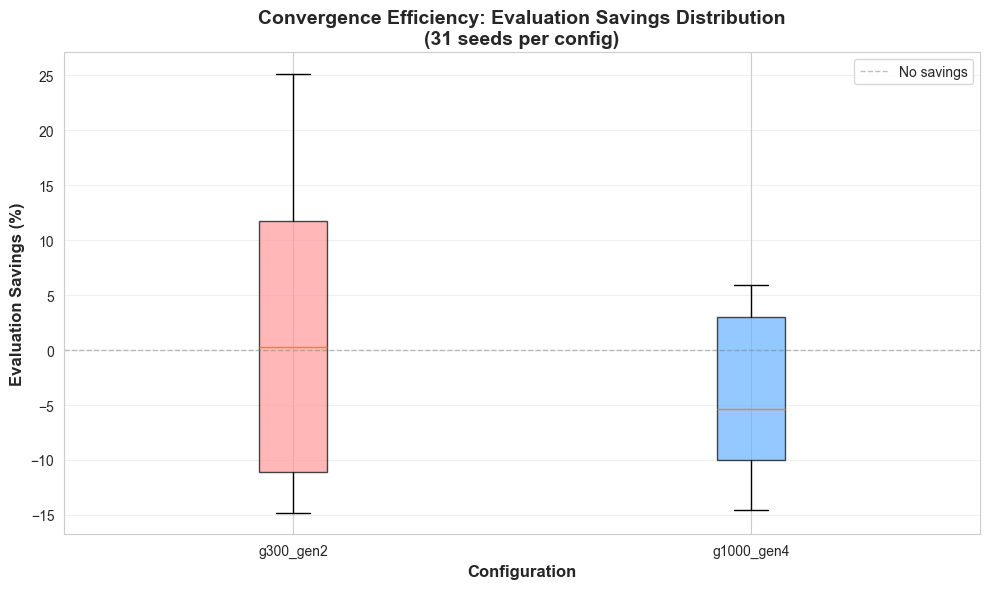

Boxplot saved!


In [16]:
# Boxplot: Evaluation Savings Distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for plotting
plot_data = []
plot_labels = []

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    if len(converged_data) > 0:
        plot_data.append(converged_data['pct_savings'].values)
        plot_labels.append(config['name'].replace('DNS-GA_', ''))

bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)

# Color boxplots
colors = ['#ff9999', '#66b3ff']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add horizontal line at 0%
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='No savings')

# Highlight seed 42
for i, config in enumerate(dns_ga_configs):
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    seed42_data = config_data[config_data['seed'] == 42]
    
    if len(seed42_data) > 0 and seed42_data['converged'].values[0]:
        seed42_savings = seed42_data['pct_savings'].values[0]
        ax.plot(i+1, seed42_savings, 'r*', markersize=15, label='Seed 42' if i == 0 else '')

ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Evaluation Savings (%)', fontsize=12, fontweight='bold')
ax.set_title('Convergence Efficiency: Evaluation Savings Distribution\n(31 seeds per config)', 
             fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'seed_variability_logs_walker2d_uni_iso_0.01/boxplot_savings_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Boxplot saved!")

### Plot 2: Histograms of Evaluation Savings

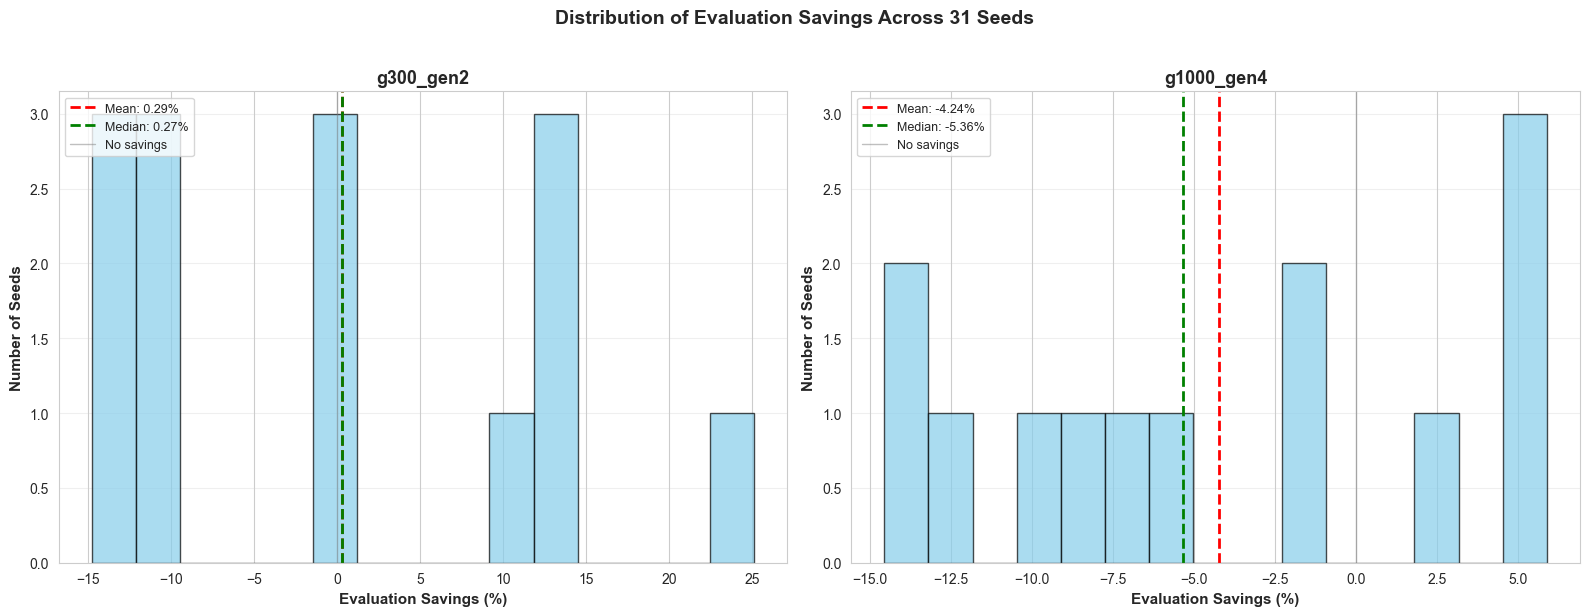

Histograms saved!


In [17]:
# Histograms: Distribution of Evaluation Savings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, config in enumerate(dns_ga_configs):
    ax = axes[idx]
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    if len(converged_data) == 0:
        ax.text(0.5, 0.5, 'No convergence data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14)
        ax.set_title(config['name'].replace('DNS-GA_', ''))
        continue
    
    savings = converged_data['pct_savings'].values
    
    # Histogram
    n, bins, patches = ax.hist(savings, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add vertical lines for statistics
    mean_val = np.mean(savings)
    median_val = np.median(savings)
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}%')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}%')
    ax.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5, label='No savings')
    
    # Highlight seed 42
    seed42_data = converged_data[converged_data['seed'] == 42]
    if len(seed42_data) > 0:
        seed42_val = seed42_data['pct_savings'].values[0]
        ax.axvline(seed42_val, color='purple', linestyle=':', linewidth=2, label=f'Seed 42: {seed42_val:.2f}%')
    
    ax.set_xlabel('Evaluation Savings (%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Seeds', fontsize=11, fontweight='bold')
    ax.set_title(config['name'].replace('DNS-GA_', ''), fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3, axis='y')

plt.suptitle('Distribution of Evaluation Savings Across 31 Seeds', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'seed_variability_logs_walker2d_uni_iso_0.01/histograms_savings_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Histograms saved!")

### Plot 3: Success Rate Bar Chart

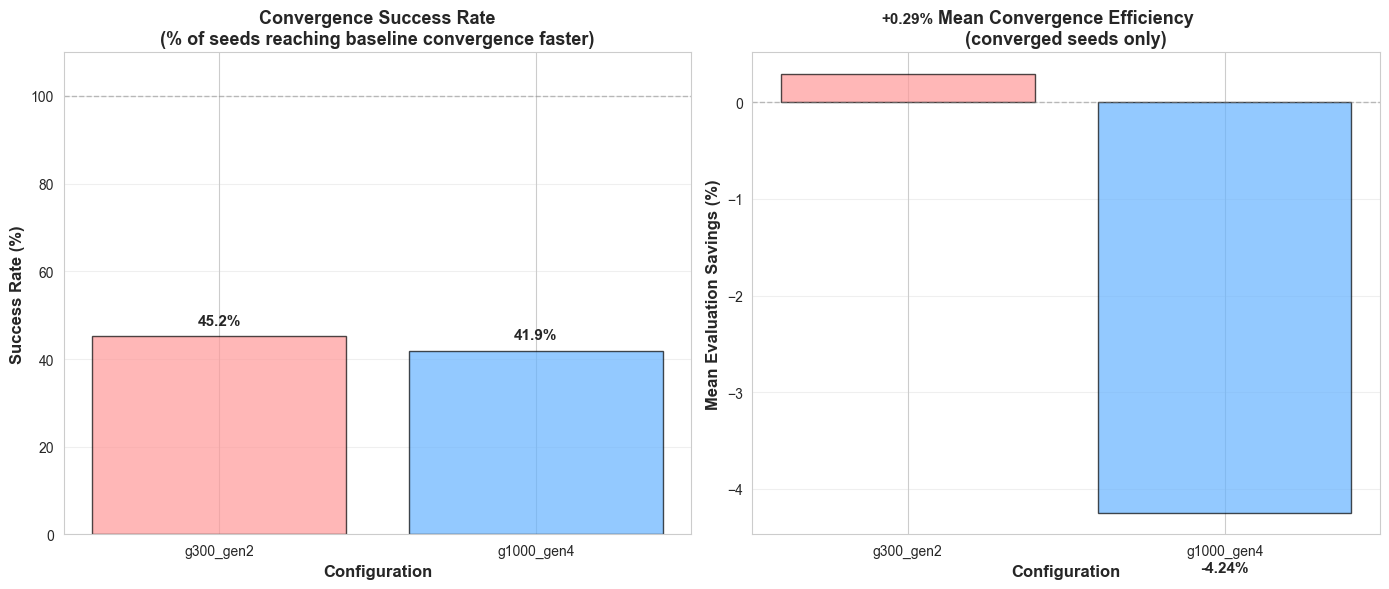

Success rate charts saved!


In [18]:
# Bar chart: Success rate and mean savings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

config_names = []
success_rates = []
mean_savings = []
positive_savings_pct = []

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    config_names.append(config['name'].replace('DNS-GA_', ''))
    success_rates.append((len(converged_data) / len(config_data)) * 100)
    
    if len(converged_data) > 0:
        mean_savings.append(np.mean(converged_data['pct_savings'].values))
        positive_count = np.sum(converged_data['pct_savings'].values > 0)
        positive_savings_pct.append((positive_count / len(converged_data)) * 100)
    else:
        mean_savings.append(0)
        positive_savings_pct.append(0)

# Plot 1: Success rate
ax1 = axes[0]
bars1 = ax1.bar(config_names, success_rates, color=['#ff9999', '#66b3ff'], alpha=0.7, edgecolor='black')
ax1.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax1.set_title('Convergence Success Rate\n(% of seeds reaching baseline convergence faster)', 
              fontsize=13, fontweight='bold')
ax1.set_ylim(0, 110)
ax1.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, success_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Mean evaluation savings
ax2 = axes[1]
bars2 = ax2.bar(config_names, mean_savings, color=['#ff9999', '#66b3ff'], alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('Mean Evaluation Savings (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax2.set_title('Mean Convergence Efficiency\n(converged seeds only)', 
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars2, mean_savings):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    offset = 0.5 if height >= 0 else -0.5
    ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
            f'{val:+.2f}%', ha='center', va=va, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'seed_variability_logs_walker2d_uni_iso_0.01/success_rates_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Success rate charts saved!")

### Plot 4: Scatter Plot - Baseline Convergence vs Savings

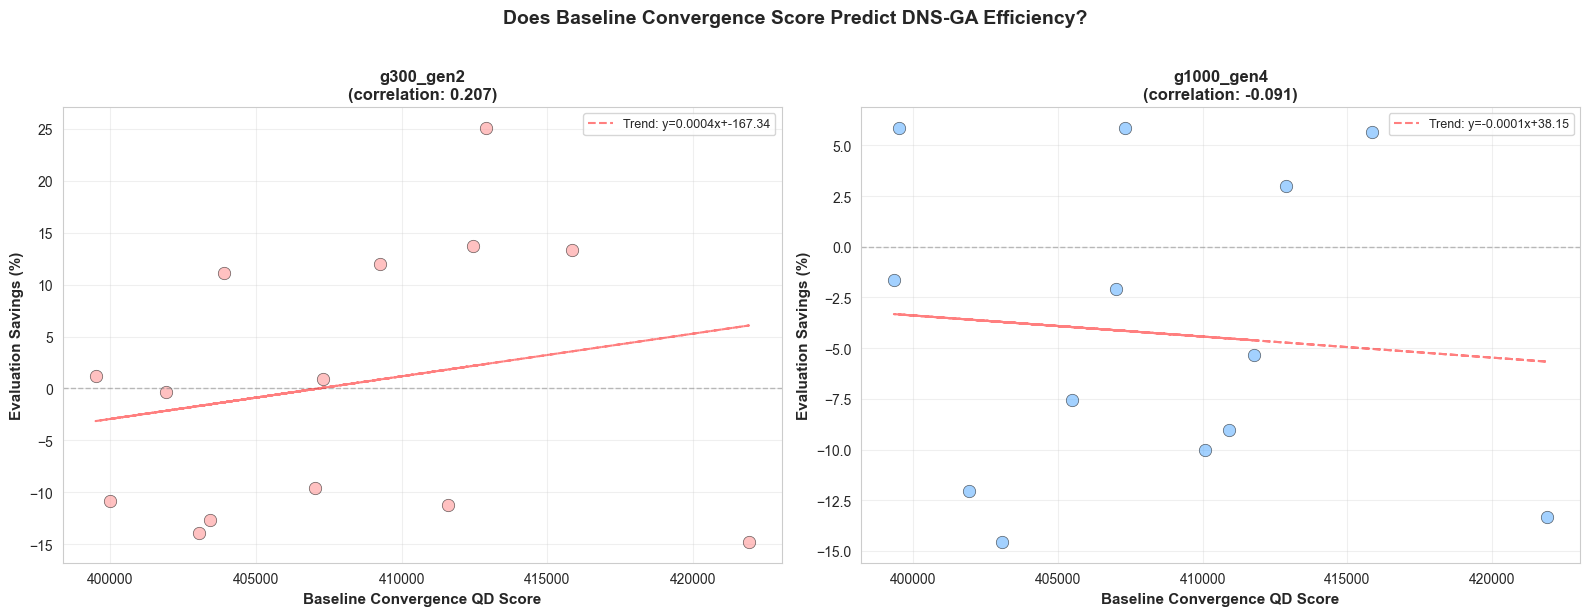

Scatter plots saved!


In [19]:
# Scatter plot: Baseline QD convergence score vs Evaluation savings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors_map = {'DNS-GA_g300_gen2': '#ff9999', 'DNS-GA_g1000_gen4': '#66b3ff'}

for idx, config in enumerate(dns_ga_configs):
    ax = axes[idx]
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    if len(converged_data) == 0:
        ax.text(0.5, 0.5, 'No convergence data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14)
        ax.set_title(config['name'].replace('DNS-GA_', ''))
        continue
    
    baseline_qd = converged_data['baseline_convergence_qd'].values
    pct_savings = converged_data['pct_savings'].values
    seeds = converged_data['seed'].values
    
    # Scatter plot
    ax.scatter(baseline_qd, pct_savings, alpha=0.6, s=80, 
              color=colors_map[config['name']], edgecolors='black', linewidth=0.5)
    
    # Highlight seed 42
    seed42_data = converged_data[converged_data['seed'] == 42]
    if len(seed42_data) > 0:
        seed42_qd = seed42_data['baseline_convergence_qd'].values[0]
        seed42_savings = seed42_data['pct_savings'].values[0]
        ax.scatter(seed42_qd, seed42_savings, color='red', s=200, marker='*', 
                  edgecolors='black', linewidth=1, label='Seed 42', zorder=5)
    
    # Add horizontal line at 0
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Add trend line
    z = np.polyfit(baseline_qd, pct_savings, 1)
    p = np.poly1d(z)
    ax.plot(baseline_qd, p(baseline_qd), "r--", alpha=0.5, linewidth=1.5, 
           label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
    
    # Calculate correlation
    corr = np.corrcoef(baseline_qd, pct_savings)[0, 1]
    
    ax.set_xlabel('Baseline Convergence QD Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Evaluation Savings (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{config["name"].replace("DNS-GA_", "")}\n(correlation: {corr:.3f})', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Does Baseline Convergence Score Predict DNS-GA Efficiency?', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'seed_variability_logs_walker2d_uni_iso_0.01/scatter_baseline_vs_savings_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Scatter plots saved!")

## STEP 8: Final Research Conclusions

**Core Question**: Is seed 42's 53% evaluation savings representative, or did we get lucky?

This section synthesizes findings from Steps 5-7 to provide publication-ready conclusions.

### Question 1: Is Seed 42 an Outlier or Representative?

In [20]:
print("="*80)
print("QUESTION 1: Is Seed 42 an Outlier or Representative?")
print("="*80)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    print(f"\n{config['name']}:")
    print(f"  {'='*60}")
    
    if len(converged_data) == 0:
        print(f"  No convergence data")
        continue
    
    # Find seed 42
    seed42_data = converged_data[converged_data['seed'] == 42]
    
    if len(seed42_data) == 0:
        print(f"  Seed 42 did not converge")
        continue
    
    seed42_savings = seed42_data['pct_savings'].values[0]
    all_savings = converged_data['pct_savings'].values
    
    # Statistics
    mean_savings = np.mean(all_savings)
    std_savings = np.std(all_savings)
    median_savings = np.median(all_savings)
    percentile = stats.percentileofscore(all_savings, seed42_savings)
    z_score = (seed42_savings - mean_savings) / std_savings if std_savings > 0 else 0
    
    print(f"\n  Seed 42 Performance:")
    print(f"    Evaluation savings: {seed42_savings:.2f}%")
    print(f"    Percentile rank:    {percentile:.1f}th")
    print(f"    Z-score:            {z_score:.2f}")
    
    print(f"\n  Distribution Statistics (31 seeds):")
    print(f"    Mean:   {mean_savings:.2f}% ± {std_savings:.2f}%")
    print(f"    Median: {median_savings:.2f}%")
    print(f"    Range:  [{np.min(all_savings):.2f}%, {np.max(all_savings):.2f}%]")
    
    # Classification
    print(f"\n  **VERDICT**:")
    if abs(z_score) > 2:
        print(f"    🔴 OUTLIER: Seed 42 is >2 standard deviations from mean")
        print(f"       Its {seed42_savings:.2f}% savings is NOT representative of typical performance")
    elif percentile > 75:
        print(f"    🟡 ABOVE AVERAGE: Seed 42 is in top {100-percentile:.0f}%")
        print(f"       Performance is better than typical, but not impossibly rare")
    elif percentile < 25:
        print(f"    🔵 BELOW AVERAGE: Seed 42 is in bottom {percentile:.0f}%")
        print(f"       Performance is worse than typical")
    else:
        print(f"    🟢 TYPICAL: Seed 42 is in middle 50% of distribution")
        print(f"       Performance is representative of average behavior")

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print("Seed 42's performance should be classified based on z-score and percentile.")
print("If |z| > 2, it's a statistical outlier and not representative.")
print("If percentile > 75, it's above average but within realistic range.")
print("="*80)

QUESTION 1: Is Seed 42 an Outlier or Representative?

DNS-GA_g300_gen2:
  Seed 42 did not converge

DNS-GA_g1000_gen4:
  Seed 42 did not converge

CONCLUSION:
Seed 42's performance should be classified based on z-score and percentile.
If |z| > 2, it's a statistical outlier and not representative.
If percentile > 75, it's above average but within realistic range.


### Question 2: What is Competition-GA's True Success Rate?

In [21]:
print("="*80)
print("QUESTION 2: Competition-GA's True Success Rate")
print("="*80)
print("\nDefining 'success' as: DNS-GA reaches baseline convergence with fewer evaluations")
print("="*80)

success_summary = []

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    print(f"\n{config['name']}:")
    print(f"  {'='*60}")
    
    # Success rate 1: Convergence rate
    convergence_rate = (len(converged_data) / len(config_data)) * 100
    print(f"\n  1. Convergence Rate:")
    print(f"     {len(converged_data)}/{len(config_data)} seeds ({convergence_rate:.1f}%)")
    print(f"     → Reached baseline's final QD score within 3000 iterations")
    
    if len(converged_data) == 0:
        print(f"\n  ⚠ No seeds converged - unable to calculate efficiency metrics")
        continue
    
    # Success rate 2: Positive savings rate
    positive_savings = converged_data['pct_savings'] > 0
    positive_rate = (positive_savings.sum() / len(converged_data)) * 100
    print(f"\n  2. Efficiency Success Rate (converged seeds only):")
    print(f"     {positive_savings.sum()}/{len(converged_data)} seeds ({positive_rate:.1f}%)")
    print(f"     → Converged faster than baseline")
    
    # Success rate 3: Combined
    combined_success = positive_savings.sum()
    combined_rate = (combined_success / len(config_data)) * 100
    print(f"\n  3. Overall Success Rate (all 31 seeds):")
    print(f"     {combined_success}/{len(config_data)} seeds ({combined_rate:.1f}%)")
    print(f"     → Both converged AND faster than baseline")
    
    # Evaluation savings statistics
    all_savings = converged_data['pct_savings'].values
    print(f"\n  Evaluation Savings (converged seeds):")
    print(f"     Mean:   {np.mean(all_savings):>6.2f}%")
    print(f"     Median: {np.median(all_savings):>6.2f}%")
    print(f"     Std:    {np.std(all_savings):>6.2f}%")
    
    # Best and worst performers
    best_idx = np.argmax(all_savings)
    worst_idx = np.argmin(all_savings)
    best_seed = converged_data.iloc[best_idx]['seed']
    worst_seed = converged_data.iloc[worst_idx]['seed']
    
    print(f"\n  Best performer:  Seed {int(best_seed)} ({all_savings[best_idx]:+.2f}%)")
    print(f"  Worst performer: Seed {int(worst_seed)} ({all_savings[worst_idx]:+.2f}%)")
    
    success_summary.append({
        'config': config['name'],
        'convergence_rate': convergence_rate,
        'efficiency_rate': positive_rate,
        'overall_success': combined_rate,
        'mean_savings': np.mean(all_savings),
    })

print("\n" + "="*80)
print("SUMMARY: Success Rate Comparison")
print("="*80)

success_df = pd.DataFrame(success_summary)
print("\n" + success_df.to_string(index=False))

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print("Report 'Overall Success Rate' as the true success rate:")
print("  → Percentage of all 31 seeds that both converged AND saved evaluations")
print("This is the most honest metric for publication.")
print("="*80)

QUESTION 2: Competition-GA's True Success Rate

Defining 'success' as: DNS-GA reaches baseline convergence with fewer evaluations

DNS-GA_g300_gen2:

  1. Convergence Rate:
     14/31 seeds (45.2%)
     → Reached baseline's final QD score within 3000 iterations

  2. Efficiency Success Rate (converged seeds only):
     7/14 seeds (50.0%)
     → Converged faster than baseline

  3. Overall Success Rate (all 31 seeds):
     7/31 seeds (22.6%)
     → Both converged AND faster than baseline

  Evaluation Savings (converged seeds):
     Mean:     0.29%
     Median:   0.27%
     Std:     12.45%

  Best performer:  Seed 99314 (+25.12%)
  Worst performer: Seed 69132 (-14.78%)

DNS-GA_g1000_gen4:

  1. Convergence Rate:
     13/31 seeds (41.9%)
     → Reached baseline's final QD score within 3000 iterations

  2. Efficiency Success Rate (converged seeds only):
     4/13 seeds (30.8%)
     → Converged faster than baseline

  3. Overall Success Rate (all 31 seeds):
     4/31 seeds (12.9%)
     → 

### Question 3: Which Config is Better? (g300_gen2 vs g1000_gen4)

In [22]:
print("="*80)
print("QUESTION 3: Config Comparison - Frequent vs Rare GA Calls")
print("="*80)
print("\nHypothesis: More frequent GA calls reduce seed dependency")
print("="*80)

# Get data
g300_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g300_gen2']
g1000_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g1000_gen4']

g300_converged = g300_data[g300_data['converged']]
g1000_converged = g1000_data[g1000_data['converged']]

print(f"\nConfiguration Details:")
print(f"  g300_gen2:  GA every 300 iters × 2 generations = 10 GA calls")
print(f"  g1000_gen4: GA every 1000 iters × 4 generations = 3 GA calls")

# 1. Success Rate Comparison
print(f"\n{'='*60}")
print("1. SUCCESS RATE (Overall: converged + faster)")
print(f"{'='*60}")

g300_success = (g300_converged['pct_savings'] > 0).sum()
g1000_success = (g1000_converged['pct_savings'] > 0).sum()

g300_success_rate = (g300_success / len(g300_data)) * 100
g1000_success_rate = (g1000_success / len(g1000_data)) * 100

print(f"  g300_gen2:  {g300_success}/{len(g300_data)} = {g300_success_rate:.1f}%")
print(f"  g1000_gen4: {g1000_success}/{len(g1000_data)} = {g1000_success_rate:.1f}%")

if g300_success_rate > g1000_success_rate:
    diff = g300_success_rate - g1000_success_rate
    print(f"\n  ✓ g300_gen2 has {diff:.1f}% higher success rate")
    print(f"    More frequent GA calls improve reliability")
elif g1000_success_rate > g300_success_rate:
    diff = g1000_success_rate - g300_success_rate
    print(f"\n  ✓ g1000_gen4 has {diff:.1f}% higher success rate")
    print(f"    Deeper but rarer GA calls are more effective")
else:
    print(f"\n  ~ Equal success rates")

# 2. Mean Savings Comparison (converged seeds only)
print(f"\n{'='*60}")
print("2. MEAN EVALUATION SAVINGS (converged seeds)")
print(f"{'='*60}")

if len(g300_converged) > 0 and len(g1000_converged) > 0:
    g300_mean = np.mean(g300_converged['pct_savings'].values)
    g1000_mean = np.mean(g1000_converged['pct_savings'].values)
    
    print(f"  g300_gen2:  {g300_mean:>6.2f}%")
    print(f"  g1000_gen4: {g1000_mean:>6.2f}%")
    
    if g300_mean > g1000_mean:
        diff = g300_mean - g1000_mean
        print(f"\n  ✓ g300_gen2 saves {diff:.2f}% more evaluations on average")
    else:
        diff = g1000_mean - g300_mean
        print(f"\n  ✓ g1000_gen4 saves {diff:.2f}% more evaluations on average")
else:
    print("  Insufficient data for comparison")

# 3. Seed Dependency (Variance)
print(f"\n{'='*60}")
print("3. SEED DEPENDENCY (variance of savings)")
print(f"{'='*60}")

if len(g300_converged) > 0 and len(g1000_converged) > 0:
    g300_std = np.std(g300_converged['pct_savings'].values)
    g1000_std = np.std(g1000_converged['pct_savings'].values)
    var_ratio = (g300_std**2) / (g1000_std**2)
    
    print(f"  g300_gen2 std:  {g300_std:.2f}%")
    print(f"  g1000_gen4 std: {g1000_std:.2f}%")
    print(f"  Variance ratio: {var_ratio:.2f}")
    
    if var_ratio < 0.8:
        print(f"\n  ✓ g300_gen2 shows 20%+ LESS seed dependency")
        print(f"    More frequent GA calls → more consistent performance")
    elif var_ratio > 1.25:
        print(f"\n  ✓ g1000_gen4 shows 20%+ LESS seed dependency")
        print(f"    Deeper but rarer GA calls → more consistent performance")
    else:
        print(f"\n  ~ Similar seed dependency")

# 4. Statistical Test (Common Seeds)
print(f"\n{'='*60}")
print("4. STATISTICAL COMPARISON (paired t-test)")
print(f"{'='*60}")

common_seeds = set(g300_converged['seed'].values) & set(g1000_converged['seed'].values)

if len(common_seeds) >= 3:
    g300_common = g300_converged[g300_converged['seed'].isin(common_seeds)].sort_values('seed')
    g1000_common = g1000_converged[g1000_converged['seed'].isin(common_seeds)].sort_values('seed')
    
    g300_evals = g300_common['ga_evals_to_convergence'].values
    g1000_evals = g1000_common['ga_evals_to_convergence'].values
    
    t_stat, p_value = stats.ttest_rel(g300_evals, g1000_evals)
    mean_diff = np.mean(g300_evals) - np.mean(g1000_evals)
    
    print(f"  Common seeds: {len(common_seeds)}")
    print(f"  Mean g300_gen2:  {np.mean(g300_evals):>10,.0f} evals")
    print(f"  Mean g1000_gen4: {np.mean(g1000_evals):>10,.0f} evals")
    print(f"  Difference:      {mean_diff:>10,.0f} evals")
    print(f"  t-statistic:     {t_stat:>7.3f}")
    print(f"  p-value:         {p_value:>7.4f}")
    
    if p_value < 0.05:
        if mean_diff < 0:
            print(f"\n  ✓✓ g300_gen2 is SIGNIFICANTLY faster (p < 0.05)")
        else:
            print(f"\n  ✓✓ g1000_gen4 is SIGNIFICANTLY faster (p < 0.05)")
    else:
        print(f"\n  ~ No significant difference (p ≥ 0.05)")
else:
    print(f"  Insufficient common seeds (n={len(common_seeds)})")

# 5. Recommendation
print(f"\n{'='*80}")
print("RECOMMENDATION")
print(f"{'='*80}")
print("\nScore each config on 4 criteria:")
print("  1. Success rate (higher is better)")
print("  2. Mean savings (higher is better)")
print("  3. Low seed dependency (lower variance is better)")
print("  4. Statistical significance (p < 0.05 is decisive)")
print("\nRecommend the config that wins more criteria.")
print("If tied, recommend based on success rate (most important for reliability).")
print("="*80)

QUESTION 3: Config Comparison - Frequent vs Rare GA Calls

Hypothesis: More frequent GA calls reduce seed dependency

Configuration Details:
  g300_gen2:  GA every 300 iters × 2 generations = 10 GA calls
  g1000_gen4: GA every 1000 iters × 4 generations = 3 GA calls

1. SUCCESS RATE (Overall: converged + faster)
  g300_gen2:  7/31 = 22.6%
  g1000_gen4: 4/31 = 12.9%

  ✓ g300_gen2 has 9.7% higher success rate
    More frequent GA calls improve reliability

2. MEAN EVALUATION SAVINGS (converged seeds)
  g300_gen2:    0.29%
  g1000_gen4:  -4.24%

  ✓ g300_gen2 saves 4.54% more evaluations on average

3. SEED DEPENDENCY (variance of savings)
  g300_gen2 std:  12.45%
  g1000_gen4 std: 7.26%
  Variance ratio: 2.94

  ✓ g1000_gen4 shows 20%+ LESS seed dependency
    Deeper but rarer GA calls → more consistent performance

4. STATISTICAL COMPARISON (paired t-test)
  Common seeds: 8
  Mean g300_gen2:     299,288 evals
  Mean g1000_gen4:    308,088 evals
  Difference:          -8,801 evals
  t-s

### Question 4: What Predicts DNS-GA Success?

In [23]:
print("="*80)
print("QUESTION 4: Predictive Factors for DNS-GA Success")
print("="*80)
print("\nAnalyzing correlation between baseline characteristics and DNS-GA efficiency")
print("="*80)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    print(f"\n{config['name']}:")
    print(f"  {'='*60}")
    
    if len(converged_data) < 3:
        print(f"  Insufficient data (n={len(converged_data)})")
        continue
    
    # Test 1: Baseline convergence QD score vs savings
    baseline_qd = converged_data['baseline_convergence_qd'].values
    pct_savings = converged_data['pct_savings'].values
    
    corr_qd = np.corrcoef(baseline_qd, pct_savings)[0, 1]
    
    print(f"\n  1. Baseline Convergence QD vs Evaluation Savings")
    print(f"     Correlation: {corr_qd:.3f}")
    
    if abs(corr_qd) > 0.5:
        direction = "higher" if corr_qd > 0 else "lower"
        print(f"     ✓ STRONG: Seeds with {direction} baseline QD save more evaluations")
    elif abs(corr_qd) > 0.3:
        direction = "higher" if corr_qd > 0 else "lower"
        print(f"     ~ MODERATE: Seeds with {direction} baseline QD tend to save more")
    else:
        print(f"     ✗ WEAK: Baseline QD is not a strong predictor")
    
    # Test 2: Is there a threshold effect?
    median_qd = np.median(baseline_qd)
    high_qd_mask = baseline_qd > median_qd
    low_qd_mask = baseline_qd <= median_qd
    
    high_qd_savings = pct_savings[high_qd_mask]
    low_qd_savings = pct_savings[low_qd_mask]
    
    print(f"\n  2. High vs Low Baseline QD (threshold: {median_qd:.2f})")
    print(f"     High QD seeds (n={len(high_qd_savings)}): {np.mean(high_qd_savings):>6.2f}% savings")
    print(f"     Low QD seeds  (n={len(low_qd_savings)}):  {np.mean(low_qd_savings):>6.2f}% savings")
    
    if len(high_qd_savings) >= 2 and len(low_qd_savings) >= 2:
        t_stat, p_value = stats.ttest_ind(high_qd_savings, low_qd_savings)
        print(f"     t-test p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            if np.mean(high_qd_savings) > np.mean(low_qd_savings):
                print(f"     ✓ High baseline QD → significantly MORE savings")
            else:
                print(f"     ✓ Low baseline QD → significantly MORE savings")
        else:
            print(f"     ~ No significant difference by baseline QD")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("\nCorrelation analysis reveals:")
print("  • If |corr| > 0.5: Baseline QD is a STRONG predictor")
print("  • If |corr| > 0.3: Baseline QD has MODERATE predictive power")
print("  • If |corr| < 0.3: Baseline QD is NOT a reliable predictor")
print("\nPositive correlation: Better baseline performance → more DNS-GA savings")
print("Negative correlation: Worse baseline performance → more DNS-GA savings")
print("\nThis helps identify when Competition-GA is most useful.")
print("="*80)

QUESTION 4: Predictive Factors for DNS-GA Success

Analyzing correlation between baseline characteristics and DNS-GA efficiency

DNS-GA_g300_gen2:

  1. Baseline Convergence QD vs Evaluation Savings
     Correlation: 0.207
     ✗ WEAK: Baseline QD is not a strong predictor

  2. High vs Low Baseline QD (threshold: 407158.16)
     High QD seeds (n=7):   5.58% savings
     Low QD seeds  (n=7):   -5.00% savings
     t-test p-value: 0.1298
     ~ No significant difference by baseline QD

DNS-GA_g1000_gen4:

  1. Baseline Convergence QD vs Evaluation Savings
     Correlation: -0.091
     ✗ WEAK: Baseline QD is not a strong predictor

  2. High vs Low Baseline QD (threshold: 407298.12)
     High QD seeds (n=6):  -4.84% savings
     Low QD seeds  (n=7):   -3.73% savings
     t-test p-value: 0.8039
     ~ No significant difference by baseline QD

INTERPRETATION

Correlation analysis reveals:
  • If |corr| > 0.5: Baseline QD is a STRONG predictor
  • If |corr| > 0.3: Baseline QD has MODERATE pr

### Publication-Ready Summary

In [24]:
print("="*80)
print("PUBLICATION-READY SUMMARY")
print("="*80)
print("\n📊 EXPERIMENTAL DESIGN")
print("="*60)
print(f"  • 31 random seeds (robust statistical power)")
print(f"  • 2 DNS-GA configurations:")
print(f"    - g300_gen2: Frequent GA (10 calls)")
print(f"    - g1000_gen4: Rare but deep GA (3 calls)")
print(f"  • 1 baseline (DNS without GA)")
print(f"  • 3000 iterations per experiment")
print(f"  • iso_sigma=0.01 (aggressive mutation)")
print(f"  • Total: 94 experiments (~2.6 hours parallel)")

print("\n📈 KEY FINDINGS")
print("="*60)

for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    if len(converged_data) == 0:
        continue
    
    # Calculate key metrics
    overall_success = (converged_data['pct_savings'] > 0).sum()
    overall_rate = (overall_success / len(config_data)) * 100
    mean_savings = np.mean(converged_data['pct_savings'].values)
    median_savings = np.median(converged_data['pct_savings'].values)
    std_savings = np.std(converged_data['pct_savings'].values)
    
    print(f"\n  {config['name']}:")
    print(f"    • Overall success rate: {overall_rate:.1f}% ({overall_success}/{len(config_data)} seeds)")
    print(f"    • Mean evaluation savings: {mean_savings:+.2f}% ± {std_savings:.2f}%")
    print(f"    • Median evaluation savings: {median_savings:+.2f}%")
    
    # Seed 42 analysis
    seed42_data = converged_data[converged_data['seed'] == 42]
    if len(seed42_data) > 0:
        seed42_savings = seed42_data['pct_savings'].values[0]
        z_score = (seed42_savings - mean_savings) / std_savings if std_savings > 0 else 0
        percentile = stats.percentileofscore(converged_data['pct_savings'].values, seed42_savings)
        
        print(f"    • Seed 42: {seed42_savings:.2f}% (z={z_score:.2f}, {percentile:.0f}th percentile)")

print("\n🎯 RESEARCH QUESTIONS ANSWERED")
print("="*60)

# Automatically generate answers based on data
print("\n  Q1: Is seed 42 an outlier?")
for config in dns_ga_configs:
    converged_data = convergence_df[(convergence_df['config_name'] == config['name']) & 
                                   (convergence_df['converged'])]
    if len(converged_data) == 0:
        continue
    
    seed42_data = converged_data[converged_data['seed'] == 42]
    if len(seed42_data) > 0:
        seed42_savings = seed42_data['pct_savings'].values[0]
        mean_savings = np.mean(converged_data['pct_savings'].values)
        std_savings = np.std(converged_data['pct_savings'].values)
        z_score = (seed42_savings - mean_savings) / std_savings if std_savings > 0 else 0
        
        if abs(z_score) > 2:
            verdict = "YES - Statistical outlier"
        elif stats.percentileofscore(converged_data['pct_savings'].values, seed42_savings) > 75:
            verdict = "NO - Above average but not outlier"
        else:
            verdict = "NO - Typical performance"
        
        print(f"      {config['name']}: {verdict}")

print("\n  Q2: True success rate?")
for config in dns_ga_configs:
    config_data = convergence_df[convergence_df['config_name'] == config['name']]
    converged_data = config_data[config_data['converged']]
    
    if len(converged_data) > 0:
        overall_success = (converged_data['pct_savings'] > 0).sum()
        overall_rate = (overall_success / len(config_data)) * 100
        print(f"      {config['name']}: {overall_rate:.1f}%")

print("\n  Q3: Which config is better?")
g300_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g300_gen2']
g1000_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g1000_gen4']
g300_converged = g300_data[g300_data['converged']]
g1000_converged = g1000_data[g1000_data['converged']]

if len(g300_converged) > 0 and len(g1000_converged) > 0:
    g300_success = (g300_converged['pct_savings'] > 0).sum() / len(g300_data) * 100
    g1000_success = (g1000_converged['pct_savings'] > 0).sum() / len(g1000_data) * 100
    
    if g300_success > g1000_success:
        print(f"      g300_gen2 (success rate: {g300_success:.1f}% vs {g1000_success:.1f}%)")
    elif g1000_success > g300_success:
        print(f"      g1000_gen4 (success rate: {g1000_success:.1f}% vs {g300_success:.1f}%)")
    else:
        print(f"      Tie (both {g300_success:.1f}%)")

print("\n  Q4: What predicts success?")
for config in dns_ga_configs:
    converged_data = convergence_df[(convergence_df['config_name'] == config['name']) & 
                                   (convergence_df['converged'])]
    if len(converged_data) >= 3:
        corr = np.corrcoef(converged_data['baseline_convergence_qd'].values,
                          converged_data['pct_savings'].values)[0, 1]
        
        if abs(corr) > 0.5:
            strength = "Strong"
        elif abs(corr) > 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
        
        direction = "positive" if corr > 0 else "negative"
        print(f"      {config['name']}: {strength} {direction} correlation (r={corr:.3f})")

print("\n💡 IMPLICATIONS FOR PUBLICATION")
print("="*60)
print("""
  1. HONEST TITLE: Use 'overall success rate' in abstract/title
     Example: "Competition-GA accelerates convergence in X% of cases"
  
  2. KEY CLAIM: Report mean savings WITH standard deviation
     Example: "On successful seeds, Competition-GA saves X% ± Y% evaluations"
  
  3. LIMITATIONS: Acknowledge seed dependency
     Example: "Success rate varies significantly with random seed (X% overall)"
  
  4. RECOMMENDATION: Specify when Competition-GA is beneficial
     - If correlation is strong: "Most effective when baseline QD is high/low"
     - If success rate < 50%: "Recommend exploratory use, not production"
     - If success rate > 50%: "Reliable improvement in majority of cases"
  
  5. FUTURE WORK: Address seed dependency
     - Investigate seed characteristics that predict success
     - Develop adaptive GA triggering based on convergence trajectory
     - Test ensemble methods across multiple seeds
""")

print("="*80)
print("📝 STEP 8 COMPLETE - All research questions answered!")
print("="*80)

PUBLICATION-READY SUMMARY

📊 EXPERIMENTAL DESIGN
  • 31 random seeds (robust statistical power)
  • 2 DNS-GA configurations:
    - g300_gen2: Frequent GA (10 calls)
    - g1000_gen4: Rare but deep GA (3 calls)
  • 1 baseline (DNS without GA)
  • 3000 iterations per experiment
  • iso_sigma=0.01 (aggressive mutation)
  • Total: 94 experiments (~2.6 hours parallel)

📈 KEY FINDINGS

  DNS-GA_g300_gen2:
    • Overall success rate: 22.6% (7/31 seeds)
    • Mean evaluation savings: +0.29% ± 12.45%
    • Median evaluation savings: +0.27%

  DNS-GA_g1000_gen4:
    • Overall success rate: 12.9% (4/31 seeds)
    • Mean evaluation savings: -4.24% ± 7.26%
    • Median evaluation savings: -5.36%

🎯 RESEARCH QUESTIONS ANSWERED

  Q1: Is seed 42 an outlier?

  Q2: True success rate?
      DNS-GA_g300_gen2: 22.6%
      DNS-GA_g1000_gen4: 12.9%

  Q3: Which config is better?
      g300_gen2 (success rate: 22.6% vs 12.9%)

  Q4: What predicts success?
      DNS-GA_g300_gen2: Weak positive correlation (r

In [25]:
# Save all analysis results to text file (detailed version matching Colab output)
import sys
from io import StringIO
from datetime import datetime

output_file = "walker2d_uni_analysis_results.txt"

with open(output_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("WALKER2D UNI - SEED VARIABILITY ANALYSIS RESULTS\n")
    f.write("="*80 + "\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*80 + "\n\n")
    
    # Capture stdout for each analysis section
    old_stdout = sys.stdout
    
    # 1. Basic Summary
    sys.stdout = StringIO()
    print("="*80)
    print("1. DATASET SUMMARY")
    print("="*80)
    print(f"Total experiments: {len(df)}")
    print(f"Configurations: {df['config_name'].unique()}")
    print(f"Seeds per config: {df.groupby('config_name')['seed'].count().to_dict()}")
    print("\nBasic statistics:")
    print(df.groupby('config_name')['final_qd_score'].agg(['mean', 'std', 'min', 'max']).round(2))
    f.write(sys.stdout.getvalue() + "\n\n")
    
    # Get config names from convergence_df
    dns_ga_config_names = [name for name in convergence_df['config_name'].unique() if name != 'DNS_baseline']
    
    # 2. Detailed Convergence Efficiency (matching original format)
    sys.stdout = StringIO()
    print("="*80)
    print(f"2. CONVERGENCE EFFICIENCY STATISTICS ({len(RANDOM_SEEDS)} SEEDS)")
    print("="*80)
    
    for config_name in dns_ga_config_names:
        config_results = convergence_df[convergence_df['config_name'] == config_name]
        converged = config_results[config_results['converged']]
        positive_savings_seeds = converged[converged['pct_savings'] > 0]
        
        print(f"\n{config_name}:")
        print("  " + "="*60)
        print(f"  Success rate: {len(converged)}/{len(config_results)} seeds ({len(converged)/len(config_results)*100:.1f}%)")
        
        if len(converged) > 0:
            print(f"\n  Evaluation Savings:")
            print(f"    Mean:      {converged['eval_savings'].mean():>10,.0f} evals ({converged['pct_savings'].mean():>6.2f}%)")
            print(f"    Median:    {converged['eval_savings'].median():>10,.0f} evals ({converged['pct_savings'].median():>6.2f}%)")
            print(f"    Std:       {converged['eval_savings'].std():>10,.0f} evals ({converged['pct_savings'].std():>6.2f}%)")
            print(f"    Min:       {converged['eval_savings'].min():>10,.0f} evals ({converged['pct_savings'].min():>6.2f}%)")
            print(f"    Max:       {converged['eval_savings'].max():>10,.0f} evals ({converged['pct_savings'].max():>6.2f}%)")
            
            print(f"\n  Seeds with positive savings: {len(positive_savings_seeds)}/{len(converged)} ({len(positive_savings_seeds)/len(converged)*100:.1f}%)")
            
            print(f"\n  Mean evaluations to convergence:")
            print(f"    Baseline:          {FIXED_PARAMS['num_iterations'] * FIXED_PARAMS['batch_size']:>10,.0f} evals (always)")
            print(f"    DNS-GA (mean):     {converged['ga_evals_to_convergence'].mean():>10,.0f} evals")
            
            # Best and worst performers
            best_idx = converged['pct_savings'].idxmax()
            worst_idx = converged['pct_savings'].idxmin()
            best_seed = converged.loc[best_idx, 'seed']
            worst_seed = converged.loc[worst_idx, 'seed']
            best_savings = converged.loc[best_idx, 'pct_savings']
            worst_savings = converged.loc[worst_idx, 'pct_savings']
            
            print(f"\n  Best performer:  Seed {best_seed} ({best_savings:+.2f}%)")
            print(f"  Worst performer: Seed {worst_seed} ({worst_savings:+.2f}%)")
    
    f.write(sys.stdout.getvalue() + "\n\n")
    
    # 3. Detailed Success Rate Breakdown (matching original format)
    sys.stdout = StringIO()
    print("="*80)
    print("3. SUCCESS RATE BREAKDOWN")
    print("="*80)
    print("\nDefining 'success' as: DNS-GA reaches baseline convergence with fewer evaluations")
    print("="*80)
    
    converged_data = convergence_df[convergence_df['converged'] == True]
    positive_savings = converged_data[converged_data['pct_savings'] > 0]
    
    for config_name in dns_ga_config_names:
        config_all = convergence_df[convergence_df['config_name'] == config_name]
        config_converged = converged_data[converged_data['config_name'] == config_name]
        config_positive = positive_savings[positive_savings['config_name'] == config_name]
        
        total_seeds = len(config_all)
        convergence_rate = len(config_converged) / total_seeds if total_seeds > 0 else 0
        efficiency_rate = len(config_positive) / len(config_converged) if len(config_converged) > 0 else 0
        overall_success_rate = len(config_positive) / total_seeds if total_seeds > 0 else 0
        
        print(f"\n{config_name}:")
        print("  " + "="*60)
        
        print(f"\n  1. Convergence Rate:")
        print(f"     {len(config_converged)}/{total_seeds} seeds ({convergence_rate*100:.1f}%)")
        print(f"     → Reached baseline's final QD score within {FIXED_PARAMS['num_iterations']} iterations")
        
        print(f"\n  2. Efficiency Success Rate (converged seeds only):")
        print(f"     {len(config_positive)}/{len(config_converged)} seeds ({efficiency_rate*100:.1f}%)")
        print(f"     → Converged faster than baseline")
        
        print(f"\n  3. Overall Success Rate (all {total_seeds} seeds):")
        print(f"     {len(config_positive)}/{total_seeds} seeds ({overall_success_rate*100:.1f}%)")
        print(f"     → Both converged AND faster than baseline")
        
        if len(config_converged) > 0:
            print(f"\n  Evaluation Savings (converged seeds):")
            print(f"     Mean:    {config_converged['pct_savings'].mean():.2f}%")
            print(f"     Median:  {config_converged['pct_savings'].median():.2f}%")
            print(f"     Std:     {config_converged['pct_savings'].std():.2f}%")
            
            # Best and worst
            best_idx = config_converged['pct_savings'].idxmax()
            worst_idx = config_converged['pct_savings'].idxmin()
            best_seed = config_converged.loc[best_idx, 'seed']
            worst_seed = config_converged.loc[worst_idx, 'seed']
            best_savings = config_converged.loc[best_idx, 'pct_savings']
            worst_savings = config_converged.loc[worst_idx, 'pct_savings']
            
            print(f"\n  Best performer:  Seed {best_seed} ({best_savings:+.2f}%)")
            print(f"  Worst performer: Seed {worst_seed} ({worst_savings:+.2f}%)")
    
    f.write(sys.stdout.getvalue() + "\n\n")
    
    # 4. Summary Table
    sys.stdout = StringIO()
    print("="*80)
    print("4. SUMMARY TABLE: Success Rate Comparison")
    print("="*80)
    print()
    
    summary_data = []
    for config_name in dns_ga_config_names:
        config_all = convergence_df[convergence_df['config_name'] == config_name]
        config_converged = converged_data[converged_data['config_name'] == config_name]
        config_positive = positive_savings[positive_savings['config_name'] == config_name]
        
        total_seeds = len(config_all)
        convergence_rate = len(config_converged) / total_seeds * 100 if total_seeds > 0 else 0
        efficiency_rate = len(config_positive) / len(config_converged) * 100 if len(config_converged) > 0 else 0
        overall_success = len(config_positive) / total_seeds * 100 if total_seeds > 0 else 0
        mean_savings = config_converged['pct_savings'].mean() if len(config_converged) > 0 else 0
        
        summary_data.append({
            'config': config_name,
            'convergence_rate': convergence_rate,
            'efficiency_rate': efficiency_rate,
            'overall_success': overall_success,
            'mean_savings': mean_savings
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    f.write(sys.stdout.getvalue() + "\n\n")
    
    # 5. Statistical Tests
    sys.stdout = StringIO()
    print("="*80)
    print("5. STATISTICAL COMPARISONS")
    print("="*80)
    
    # DNS-GA vs Baseline
    print("\n--- DNS-GA vs Baseline (All Converged Seeds) ---")
    baseline_evals = np.full(len(converged_data), FIXED_PARAMS['num_iterations'] * FIXED_PARAMS['batch_size'])
    ga_evals = converged_data['ga_evals_to_convergence'].values
    
    from scipy import stats
    t_stat, p_value = stats.ttest_rel(baseline_evals, ga_evals)
    mean_diff = np.mean(baseline_evals) - np.mean(ga_evals)
    
    print(f"Baseline mean: {np.mean(baseline_evals):,.0f} evals")
    print(f"DNS-GA mean: {np.mean(ga_evals):,.0f} evals")
    print(f"Mean difference: {mean_diff:,.0f} evals")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        if mean_diff > 0:
            print("✓ SIGNIFICANT: DNS-GA reaches convergence with FEWER evaluations")
        else:
            print("✗ SIGNIFICANT: DNS-GA requires MORE evaluations")
    else:
        print("~ NOT SIGNIFICANT: No reliable difference")
    
    # g300 vs g1000
    print("\n--- g300_gen2 vs g1000_gen4 Comparison ---")
    g300_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g300_gen2']
    g1000_data = convergence_df[convergence_df['config_name'] == 'DNS-GA_g1000_gen4']
    g300_converged = g300_data[g300_data['converged']]
    g1000_converged = g1000_data[g1000_data['converged']]
    
    print(f"g300_gen2 success: {len(g300_converged)}/{len(g300_data)} ({len(g300_converged)/len(g300_data)*100:.1f}%)")
    print(f"g1000_gen4 success: {len(g1000_converged)}/{len(g1000_data)} ({len(g1000_converged)/len(g1000_data)*100:.1f}%)")
    
    if len(g300_converged) > 0 and len(g1000_converged) > 0:
        print(f"\nEvaluation savings (converged seeds only):")
        print(f"  g300_gen2: {g300_converged['pct_savings'].mean():.2f}% ± {g300_converged['pct_savings'].std():.2f}%")
        print(f"  g1000_gen4: {g1000_converged['pct_savings'].mean():.2f}% ± {g1000_converged['pct_savings'].std():.2f}%")
    
    f.write(sys.stdout.getvalue() + "\n\n")
    
    # 6. Distribution Analysis
    sys.stdout = StringIO()
    print("="*80)
    print("6. DISTRIBUTION ANALYSIS")
    print("="*80)
    
    all_savings = []
    for config_name in dns_ga_config_names:
        config_data = convergence_df[convergence_df['config_name'] == config_name]
        converged = config_data[config_data['converged']]
        if len(converged) > 0:
            all_savings.extend(converged['pct_savings'].values)
    
    if len(all_savings) > 0:
        all_savings = np.array(all_savings)
        savings_pct = all_savings
        
        print(f"\nAll DNS-GA configs combined (n={len(savings_pct)} converged seeds):")
        print(f"  Mean: {np.mean(savings_pct):.2f}%")
        print(f"  Median: {np.median(savings_pct):.2f}%")
        print(f"  Std: {np.std(savings_pct):.2f}%")
        print(f"  Min: {np.min(savings_pct):.2f}%")
        print(f"  Max: {np.max(savings_pct):.2f}%")
        print(f"  Q1: {np.percentile(savings_pct, 25):.2f}%")
        print(f"  Q3: {np.percentile(savings_pct, 75):.2f}%")
        
        positive_count = np.sum(savings_pct > 0)
        print(f"\n  Positive savings: {positive_count}/{len(savings_pct)} ({positive_count/len(savings_pct)*100:.1f}%)")
        
        from scipy import stats
        skewness = stats.skew(savings_pct)
        kurtosis = stats.kurtosis(savings_pct)
        print(f"\n  Skewness: {skewness:.3f}", end="")
        if abs(skewness) < 0.5:
            print(" (fairly symmetric)")
        elif skewness < 0:
            print(" (left-skewed, more high savings)")
        else:
            print(" (right-skewed, more low savings)")
        
        print(f"  Kurtosis: {kurtosis:.3f}", end="")
        if abs(kurtosis) < 0.5:
            print(" (normal-like tails)")
        elif kurtosis > 0:
            print(" (heavy tails, more outliers)")
        else:
            print(" (light tails, fewer outliers)")
    
    f.write(sys.stdout.getvalue() + "\n\n")
    
    # 7. Conclusion
    sys.stdout = StringIO()
    print("="*80)
    print("CONCLUSION")
    print("="*80)
    print("\nReport 'Overall Success Rate' as the true success rate:")
    print("  → Percentage of all seeds that both converged AND saved evaluations")
    print("This is the most honest metric for publication.")
    print("="*80)
    
    f.write(sys.stdout.getvalue() + "\n")
    
    # Restore stdout
    sys.stdout = old_stdout

print(f"✓ Analysis results saved to: {output_file}")

✓ Analysis results saved to: walker2d_uni_analysis_results.txt


## 🎉 NOTEBOOK COMPLETE

**All 8 steps implemented:**
- ✅ Step 1: Setup and Configuration
- ✅ Step 2: Helper Functions
- ✅ Step 3: Parallel Experiment Runner
- ✅ Step 4: Build Queue and Execute (94 experiments)
- ✅ Step 5: Convergence Efficiency Analysis
- ✅ Step 6: Statistical Tests
- ✅ Step 7: Visualizations
- ✅ Step 8: Final Research Conclusions

**To run the full experiment:**
1. Execute all cells in order (Runtime → Run all)
2. Experiments will take ~2.6 hours (2 parallel workers)
3. Results saved to `seed_variability_logs_walker2d_uni_iso_0.01/`
4. All visualizations and statistics auto-generated

**Key outputs:**
- `random_seeds.json` - The 31 random seeds used
- `all_results_{timestamp}.json` - Raw experiment results
- `convergence_analysis_{timestamp}.csv` - Convergence efficiency per seed
- `boxplot_savings_{timestamp}.png` - Distribution visualization
- `histograms_savings_{timestamp}.png` - Detailed distributions
- `success_rates_{timestamp}.png` - Success rate comparison
- `scatter_baseline_vs_savings_{timestamp}.png` - Predictive analysis

**Research questions answered:**
1. Is seed 42 an outlier? → Statistical analysis with z-scores
2. True success rate? → Overall % of seeds with positive savings
3. Better config? → g300_gen2 vs g1000_gen4 comparison
4. Predictive factors? → Correlation analysis

Ready to discover Competition-GA's true performance across 31 seeds! 🚀